<a href="https://colab.research.google.com/github/Giridhar88/Music-Generation/blob/main/MG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1: INSTALLING DEPENDENCIES
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.1 MB/s eta 0:00:00

✓ Dependencies installed!

Created directory: data/emopia

STEP 2: LOADING EMOPIA DATASET


62988951552it [00:28, 2179137651.86it/s]


Successfully downloaded source : /content/data/emopia/EMOPIA_2.2.zip .
Extracting archive : /content/data/emopia/EMOPIA_2.2.zip ...
Successfully extracted archive : /content/data/emopia .

✓ Dataset loaded!
Total tracks: 1071

STEP 3: LOADING EMOTION LABELS FROM TEXT FILES

✓ Total labeled files: 0

Emotion Distribution:

STEP 4: CREATING INDEX-TO-EMOTION MAPPING
Trying alternative method to match files...
✓ Successfully mapped 0 tracks to emotions

STEP 5: SAMPLE TRACK INSPECTION

Sample Track #0:
  Resolution: 384 ticks per quarter note
  Number of tracks: 1
  Tempo: 120.0 BPM
  Emotion Label: QUnknown

  First Track Stats:
    Total notes: 169
    Pitch range: 36 - 91
    Avg duration: 667.93 ticks

STEP 6: EMOTION DISTRIBUTION PLOT


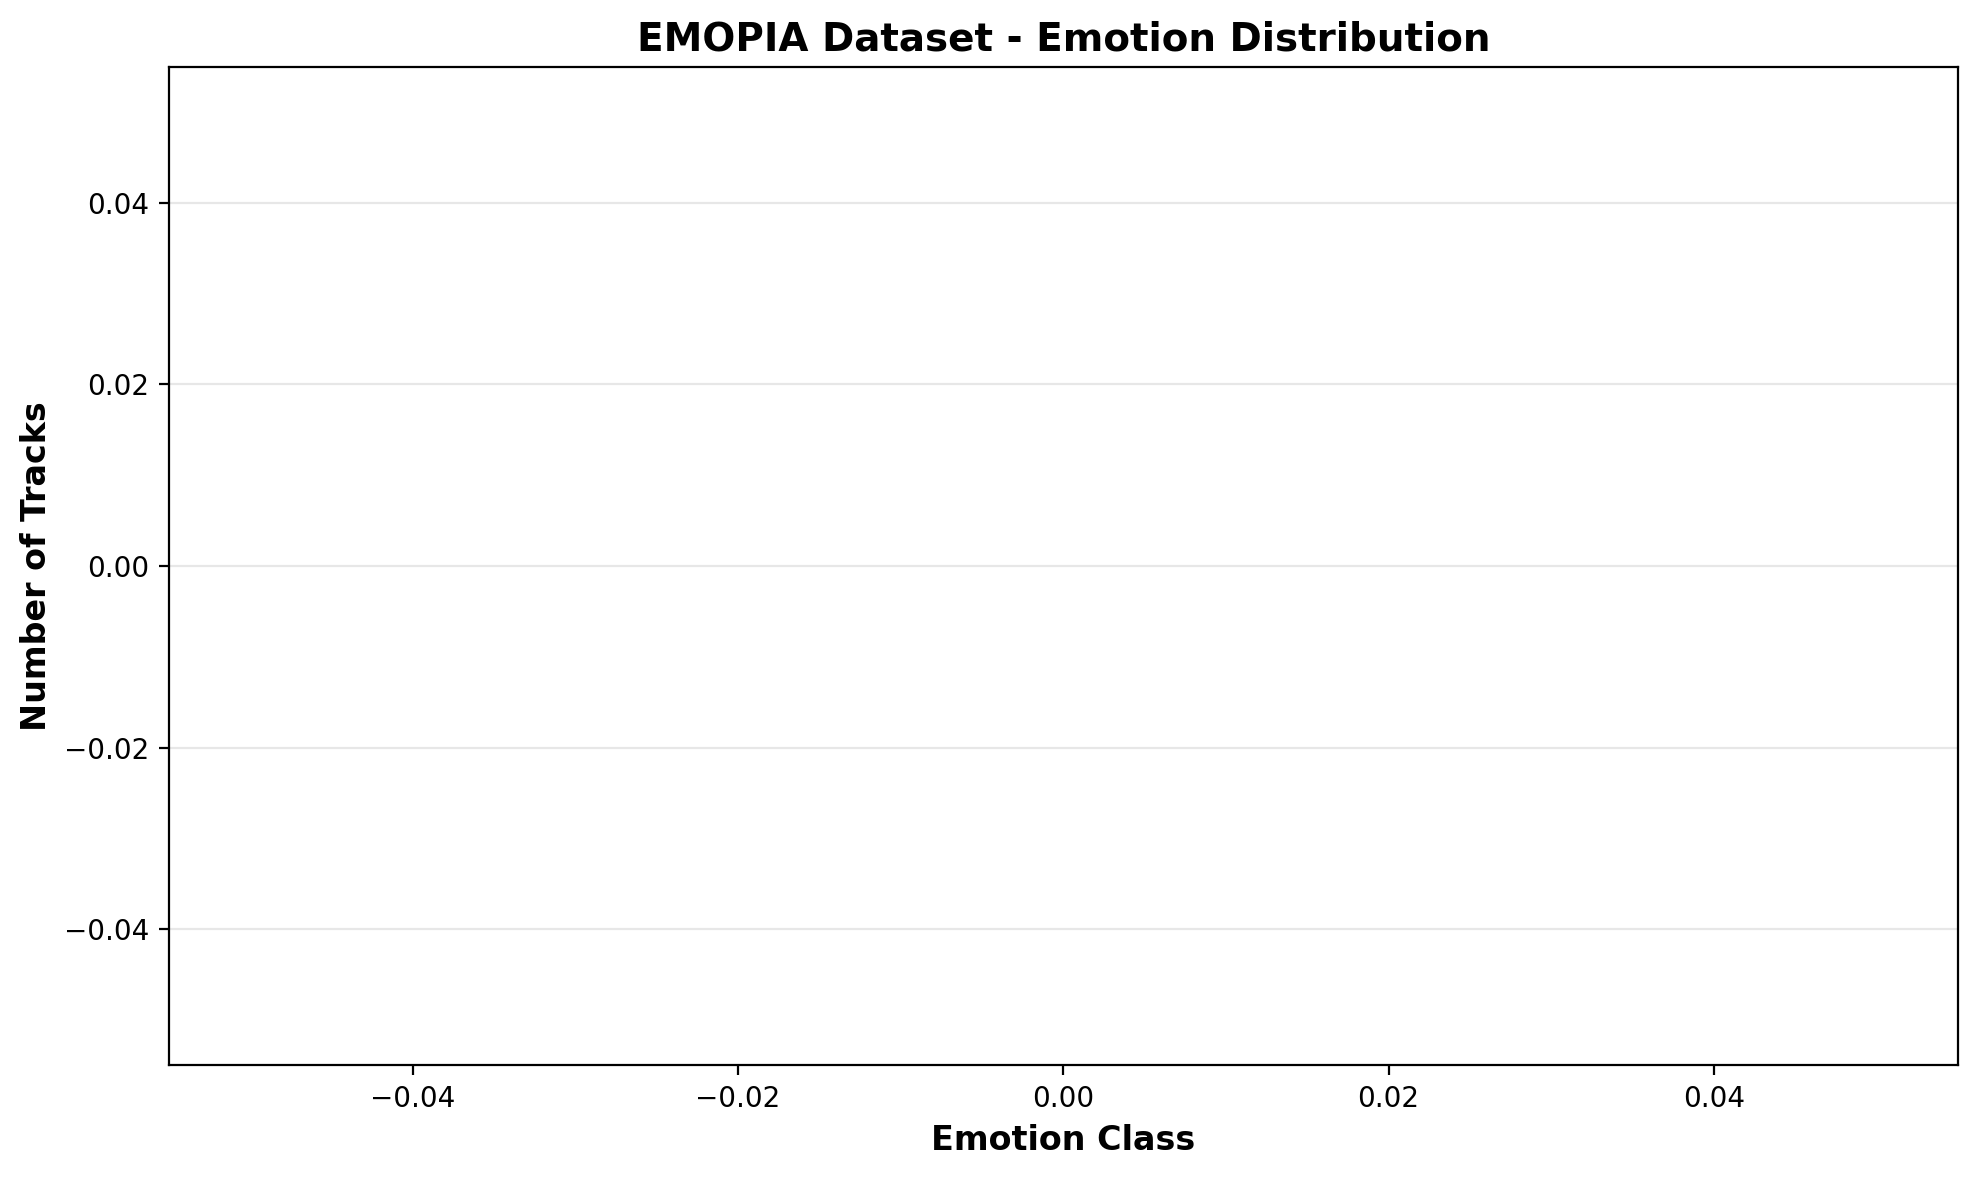


✓ STEP 1 COMPLETE - DATA LOADED SUCCESSFULLY!

Dataset Summary:
  Total tracks: 1071
  Labeled tracks: 0
  Emotion distribution: {}

Next: Run Step 2 to preprocess MIDI into piano roll format


In [ ]:
# Step 1: Environment Setup & EMOPIA Data Loading (FIXED)


print("=" * 60)
print("STEP 1: INSTALLING DEPENDENCIES")
print("=" * 60)

# Install required packages
!pip install -q muspy torch torchvision pretty_midi numpy matplotlib

print("\n✓ Dependencies installed!")

# Import libraries
import muspy
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import glob

# Create the data directory if it doesn't exist
data_dir = "data/emopia"
os.makedirs(data_dir, exist_ok=True)
print(f"\nCreated directory: {data_dir}")


print("\n" + "=" * 60)
print("STEP 2: LOADING EMOPIA DATASET")
print("=" * 60)

# Dataset is already downloaded, just load it
emopia = muspy.EMOPIADataset(data_dir, download_and_extract=True)
print(f"\n✓ Dataset loaded!")
print(f"Total tracks: {len(emopia)}")

print("\n" + "=" * 60)
print("STEP 3: LOADING EMOTION LABELS FROM TEXT FILES")
print("=" * 60)

# EMOPIA stores labels in text files organized by quadrant
# Structure: data/emopia/midis/Q1/, Q2/, Q3/, Q4/
base_path = os.path.join(data_dir, "midis")


emotion_labels = {}  # filename -> emotion_class mapping

for q in [1, 2, 3, 4]:
    q_folder = os.path.join(base_path, f"Q{q}")
    if os.path.exists(q_folder):
        midi_files = glob.glob(os.path.join(q_folder, "*.mid"))
        print(f"Q{q}: Found {len(midi_files)} files")
        for midi_path in midi_files:
            filename = os.path.basename(midi_path)
            emotion_labels[filename] = q

print(f"\n✓ Total labeled files: {len(emotion_labels)}")

# Count distribution
emotion_counts = Counter(emotion_labels.values())
print(f"\nEmotion Distribution:")
for q in sorted(emotion_counts.keys()):
    print(f"  Q{q}: {emotion_counts[q]} tracks")

# Create a mapping from dataset index to emotion label
print("\n" + "=" * 60)
print("STEP 4: CREATING INDEX-TO-EMOTION MAPPING")
print("=" * 60)

index_to_emotion = {}
for idx in range(len(emopia)):
    # Get the file path from muspy dataset
    try:
        music = emopia[idx]
        # Try to extract filename from the source path
        if hasattr(music, 'metadata') and music.metadata and hasattr(music.metadata, 'source_filename'):
            filename = music.metadata.source_filename
            if filename in emotion_labels:
                index_to_emotion[idx] = emotion_labels[filename]
    except:
        pass

# If above doesn't work, try direct path matching
if len(index_to_emotion) == 0:
    print("Trying alternative method to match files...")
    # Get all MIDI file paths
    all_midi_paths = []
    for q in [1, 2, 3, 4]:
        q_folder = os.path.join(base_path, f"Q{q}")
        if os.path.exists(q_folder):
            all_midi_paths.extend(glob.glob(os.path.join(q_folder, "*.mid")))

    # Sort both lists to ensure matching
    all_midi_paths.sort()

    # Assign emotions based on sorted order
    for idx, midi_path in enumerate(all_midi_paths):
        if idx < len(emopia):
            filename = os.path.basename(midi_path)
            if filename in emotion_labels:
                index_to_emotion[idx] = emotion_labels[filename]


print(f"✓ Successfully mapped {len(index_to_emotion)} tracks to emotions")

# Show sample track info
print("\n" + "=" * 60)
print("STEP 5: SAMPLE TRACK INSPECTION")
print("=" * 60)

sample_idx = 0
sample_music = emopia[sample_idx]

print(f"\nSample Track #{sample_idx}:")
print(f"  Resolution: {sample_music.resolution} ticks per quarter note")
print(f"  Number of tracks: {len(sample_music.tracks)}")
print(f"  Tempo: {sample_music.tempos[0].qpm if sample_music.tempos else 'N/A'} BPM")
print(f"  Emotion Label: Q{index_to_emotion.get(sample_idx, 'Unknown')}")

# Show note statistics for first track
if sample_music.tracks:
    first_track = sample_music.tracks[0]
    if first_track.notes:
        pitches = [note.pitch for note in first_track.notes]
        durations = [note.duration for note in first_track.notes]
        print(f"\n  First Track Stats:")
        print(f"    Total notes: {len(first_track.notes)}")
        print(f"    Pitch range: {min(pitches)} - {max(pitches)}")
        print(f"    Avg duration: {np.mean(durations):.2f} ticks")


# Visualize emotion distribution
print("\n" + "=" * 60)
print("STEP 6: EMOTION DISTRIBUTION PLOT")
print("=" * 60)

plt.figure(figsize=(10, 6))
emotions_list = sorted(emotion_counts.keys())
counts = [emotion_counts[e] for e in emotions_list]

emotion_names = {
    1: "Q1: Happy/Excited\n(HVHA)",
    2: "Q2: Angry/Tense\n(LVHA)",
    3: "Q3: Sad/Depressed\n(LVLA)",
    4: "Q4: Peaceful/Relaxed\n(HVLA)"
}

labels = [emotion_names.get(e, f"Q{e}") for e in emotions_list]

bars = plt.bar(labels, counts, color=['#4CAF50', '#F44336', '#2196F3', '#FF9800'])
plt.xlabel('Emotion Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Tracks', fontsize=12, fontweight='bold')
plt.title('EMOPIA Dataset - Emotion Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✓ STEP 1 COMPLETE - DATA LOADED SUCCESSFULLY!")
print("=" * 60)
print(f"\nDataset Summary:")
print(f"  Total tracks: {len(emopia)}")
print(f"  Labeled tracks: {len(index_to_emotion)}")
print(f"  Emotion distribution: {dict(emotion_counts)}")
print("\nNext: Run Step 2 to preprocess MIDI into piano roll format")

# Save the mapping for next steps
np.save('index_to_emotion.npy', index_to_emotion)

STEP 2: MIDI TO PIANO ROLL PREPROCESSING

Configuration:
  Bars: 4
  Time steps: 64
  Pitch range: 128
  Resolution: 16th notes
Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.

Dataset size: 1071 tracks

PREPROCESSING ALL TRACKS...


Converting MIDI to piano rolls: 100%|██████████| 1071/1071 [00:13<00:00, 77.76it/s]



✓ Preprocessing complete!
  Valid tracks: 1071
  Piano roll shape: (1071, 64, 128)
  Data range: [0.00, 1.00]
  Average density: 0.0443 (ratio of active notes)

Saving preprocessed data...
✓ Saved to piano_rolls.npy

VISUALIZATION: SAMPLE PIANO ROLLS


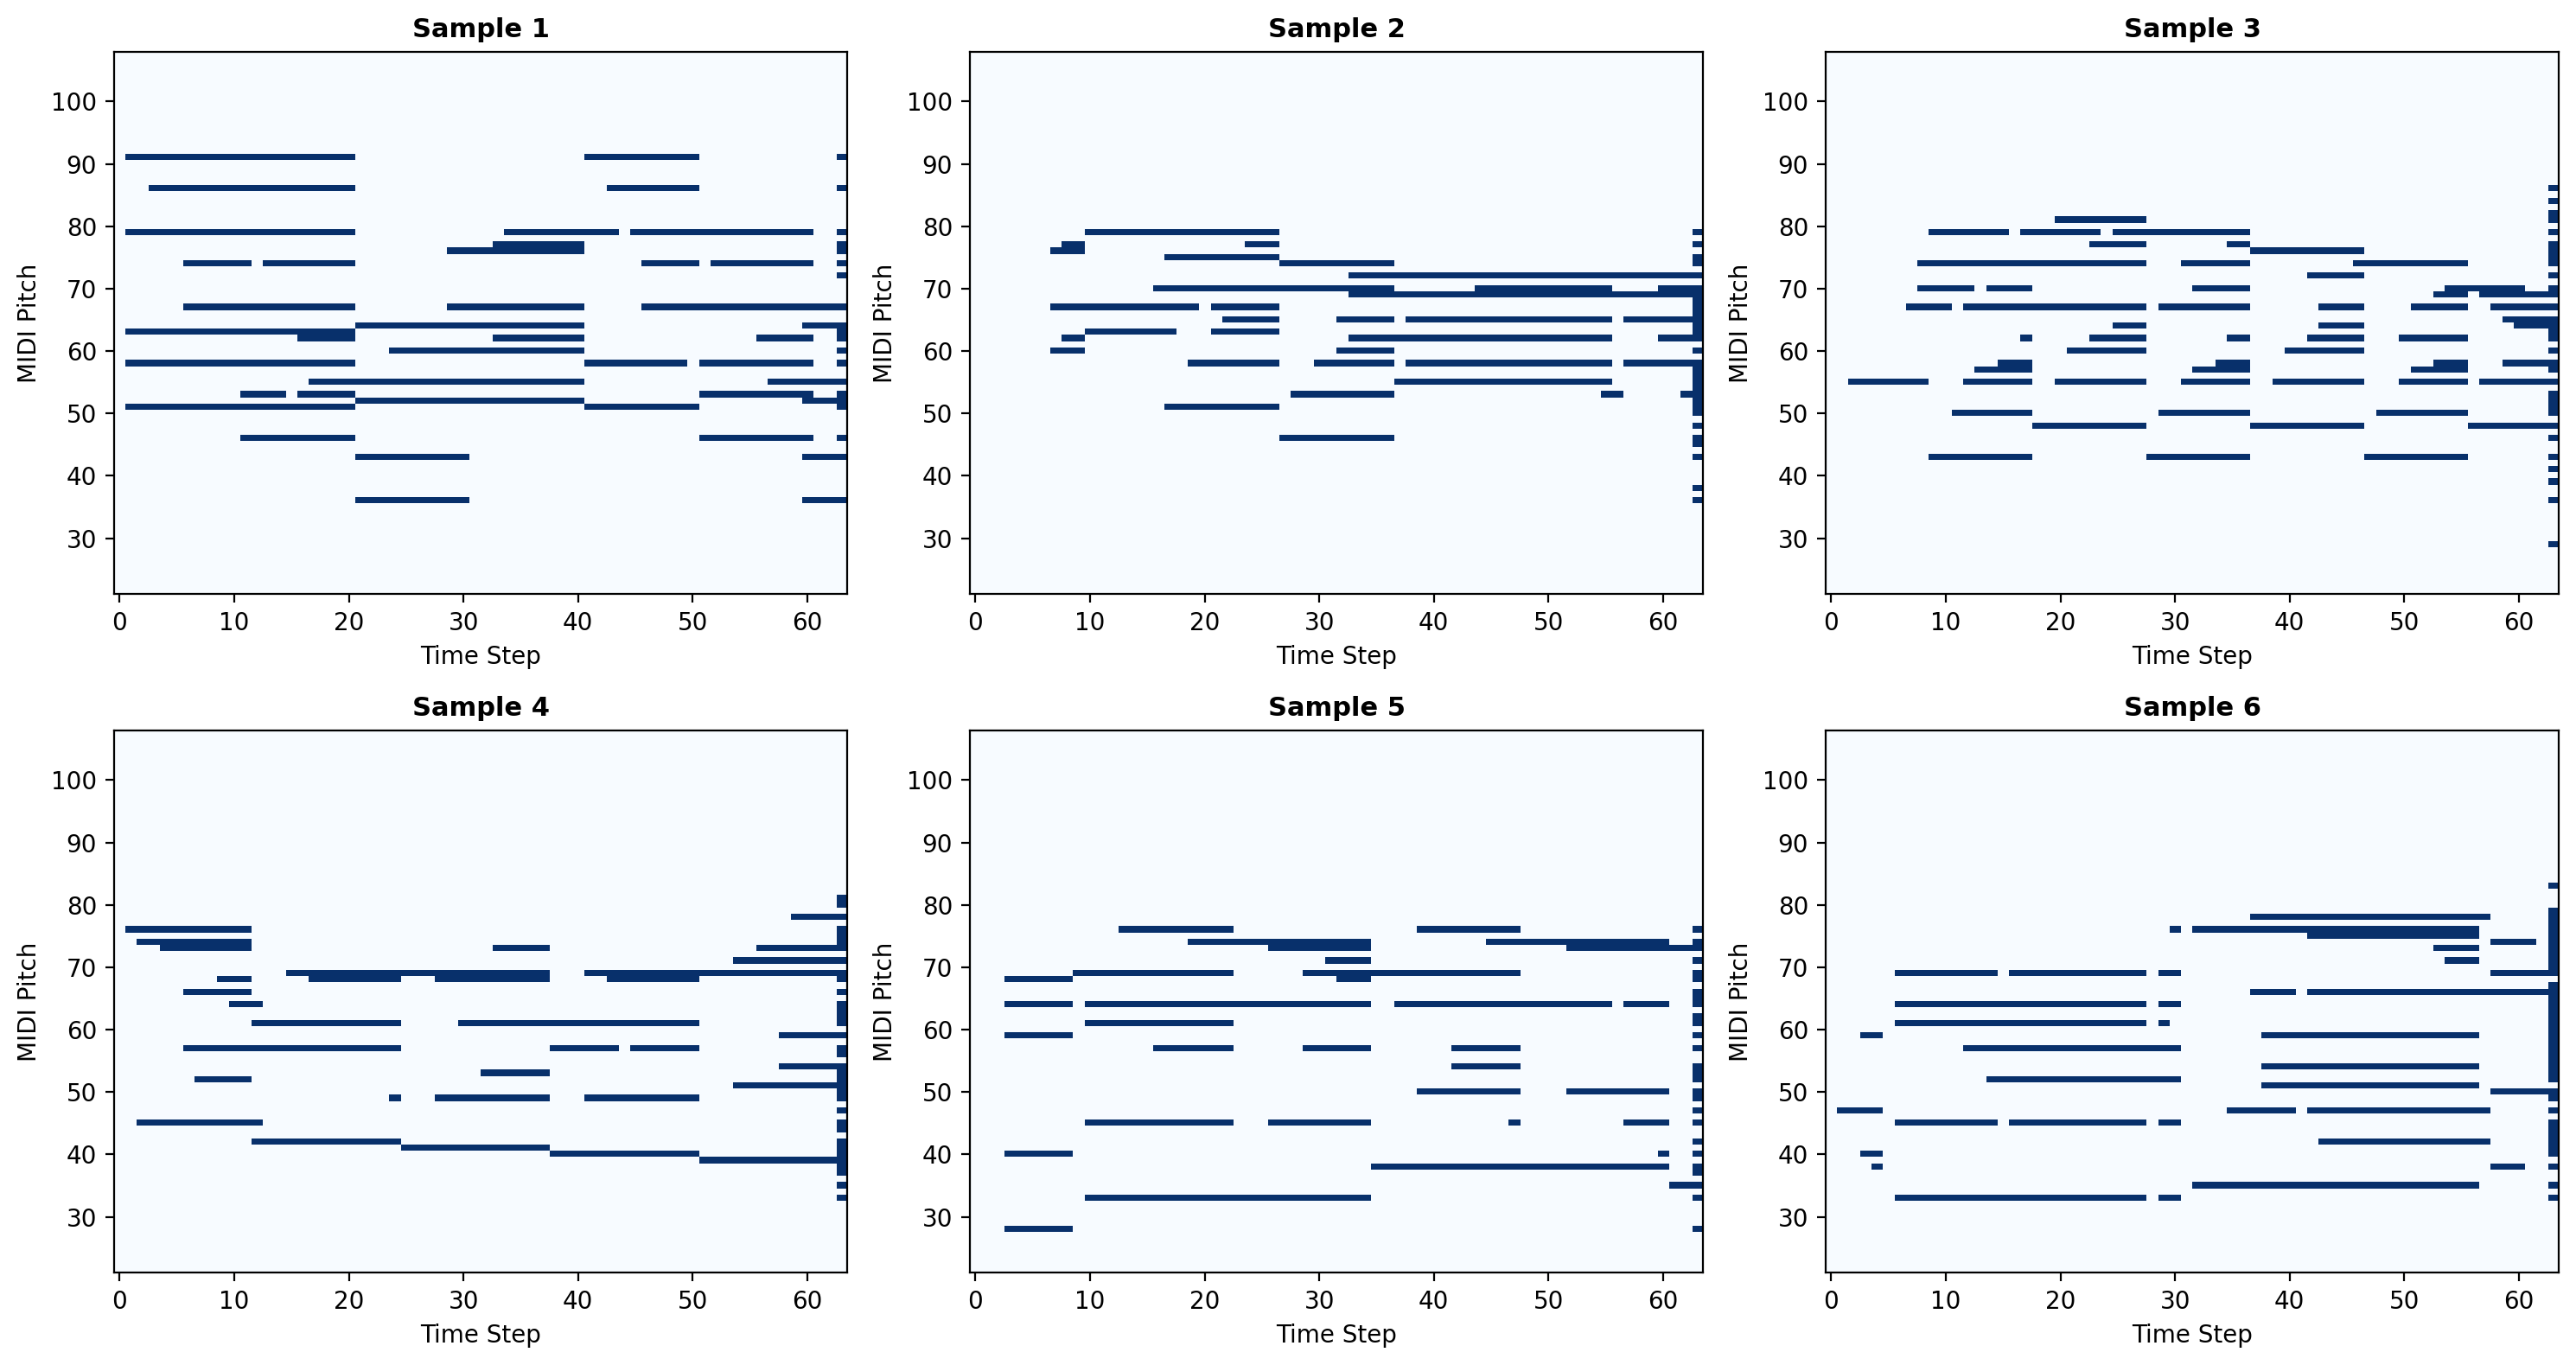


✓ Saved visualization to piano_roll_samples.png

DATASET STATISTICS

Notes per track:
  Mean: 363.0
  Std: 123.8
  Min: 45
  Max: 987

Pitch range used:
  Lowest: 22 (MIDI)
  Highest: 105 (MIDI)
  Active pitches: 84/128

✓ STEP 2 COMPLETE - DATA PREPROCESSED!

Ready for training with 1071 samples
Next: Run Step 3 to build and train the VAE


In [ ]:
# Step 2: MIDI to Piano Roll Preprocessing
# Run this after Step 1

import muspy
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

print("=" * 60)
print("STEP 2: MIDI TO PIANO ROLL PREPROCESSING")
print("=" * 60)

# Configuration
BARS = 4  # Generate 4 bars of music
BEATS_PER_BAR = 4
TIME_STEPS_PER_BEAT = 4  # 16th note resolution
TOTAL_TIME_STEPS = BARS * BEATS_PER_BAR * TIME_STEPS_PER_BEAT  # 64 steps
PITCH_RANGE = 128  # Full MIDI range (0-127)

print(f"\nConfiguration:")
print(f"  Bars: {BARS}")
print(f"  Time steps: {TOTAL_TIME_STEPS}")
print(f"  Pitch range: {PITCH_RANGE}")
print(f"  Resolution: 16th notes")

# Load dataset (already downloaded)
emopia = muspy.EMOPIADataset("data/emopia", download_and_extract=True)
print(f"\nDataset size: {len(emopia)} tracks")

def music_to_piano_roll(music, total_steps=TOTAL_TIME_STEPS):
    """
    Convert MusPy Music object to piano roll.
    Returns: numpy array of shape (total_steps, 128)
    """
    # Initialize empty piano roll
    piano_roll = np.zeros((total_steps, PITCH_RANGE), dtype=np.float32)

    # Get all notes from all tracks
    all_notes = []
    for track in music.tracks:
        if track.notes:
            all_notes.extend(track.notes)

    if not all_notes:
        return piano_roll

    # Convert time to steps (assuming 4/4 time, resolution = ticks per quarter note)
    resolution = music.resolution if music.resolution else 480
    ticks_per_step = resolution / TIME_STEPS_PER_BEAT

    # Fill piano roll
    for note in all_notes:
        # Convert time to step index
        step_start = int(note.time / ticks_per_step)
        step_end = int((note.time + note.duration) / ticks_per_step)

        # Clip to valid range
        step_start = max(0, min(step_start, total_steps - 1))
        step_end = max(0, min(step_end, total_steps))

        # Set note on
        if step_start < total_steps and 0 <= note.pitch < PITCH_RANGE:
            for step in range(step_start, step_end):
                if step < total_steps:
                    piano_roll[step, note.pitch] = 1.0

    return piano_roll

print("\n" + "=" * 60)
print("PREPROCESSING ALL TRACKS...")
print("=" * 60)

# Process all tracks
piano_rolls = []
valid_tracks = 0

for idx in tqdm(range(len(emopia)), desc="Converting MIDI to piano rolls"):
    try:
        music = emopia[idx]
        piano_roll = music_to_piano_roll(music)

        # Only keep piano rolls with some notes
        if piano_roll.sum() > 10:  # At least 10 active notes
            piano_rolls.append(piano_roll)
            valid_tracks += 1
    except Exception as e:
        # Skip problematic files
        continue

piano_rolls = np.array(piano_rolls)  # Shape: (N, 64, 128)

print(f"\n✓ Preprocessing complete!")
print(f"  Valid tracks: {valid_tracks}")
print(f"  Piano roll shape: {piano_rolls.shape}")
print(f"  Data range: [{piano_rolls.min():.2f}, {piano_rolls.max():.2f}]")
print(f"  Average density: {piano_rolls.mean():.4f} (ratio of active notes)")

# Save preprocessed data
print("\nSaving preprocessed data...")
np.save('piano_rolls.npy', piano_rolls)
print("✓ Saved to piano_rolls.npy")

# Visualize samples
print("\n" + "=" * 60)
print("VISUALIZATION: SAMPLE PIANO ROLLS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    if i < len(piano_rolls):
        ax = axes[i]
        # Transpose to show pitch on Y-axis, time on X-axis
        ax.imshow(piano_rolls[i].T, aspect='auto', cmap='Blues', origin='lower')
        ax.set_xlabel('Time Step', fontsize=10)
        ax.set_ylabel('MIDI Pitch', fontsize=10)
        ax.set_title(f'Sample {i+1}', fontsize=11, fontweight='bold')
        ax.set_ylim([21, 108])  # Standard piano range (A0 to C8)

plt.tight_layout()
plt.savefig('piano_roll_samples.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved visualization to piano_roll_samples.png")

# Statistics
print("\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

note_counts = piano_rolls.sum(axis=(1, 2))  # Total notes per track
pitch_usage = piano_rolls.sum(axis=(0, 1))  # Usage per pitch

print(f"\nNotes per track:")
print(f"  Mean: {note_counts.mean():.1f}")
print(f"  Std: {note_counts.std():.1f}")
print(f"  Min: {note_counts.min():.0f}")
print(f"  Max: {note_counts.max():.0f}")

active_pitches = np.where(pitch_usage > 0)[0]
print(f"\nPitch range used:")
print(f"  Lowest: {active_pitches.min()} (MIDI)")
print(f"  Highest: {active_pitches.max()} (MIDI)")
print(f"  Active pitches: {len(active_pitches)}/128")

print("\n" + "=" * 60)
print("✓ STEP 2 COMPLETE - DATA PREPROCESSED!")
print("=" * 60)
print(f"\nReady for training with {len(piano_rolls)} samples")
print("Next: Run Step 3 to build and train the VAE")

STEP 3: VAE ARCHITECTURE & TRAINING

Device: cpu
Loaded data: (1071, 64, 128)

VAE Configuration:
  Latent dimension: 512
  Hidden dimension: 1024
  Batch size: 32
  Epochs: 50
  Learning rate: 0.001
  Beta (KL weight): 0.1

Dataset size: 1071 samples
Batches per epoch: 34

MODEL ARCHITECTURE
MusicVAE(
  (encoder): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=512, out_features=512, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=512, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_

Epoch 1/50: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s, Loss=1121.39, Recon=1121.29, KL=0.92]


Epoch 1: Loss=1727.77, Recon=1725.40, KL=23.74


Epoch 2/50: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s, Loss=1239.60, Recon=1238.57, KL=10.32]


Epoch 2: Loss=1153.85, Recon=1153.30, KL=5.48


Epoch 3/50: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s, Loss=1159.54, Recon=1157.05, KL=24.96]


Epoch 3: Loss=1140.99, Recon=1139.36, KL=16.31


Epoch 4/50: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s, Loss=1160.71, Recon=1156.34, KL=43.70]


Epoch 4: Loss=1118.93, Recon=1116.23, KL=26.98


Epoch 5/50: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s, Loss=1035.44, Recon=1031.75, KL=36.97]


Epoch 5: Loss=1066.52, Recon=1062.38, KL=41.39


Epoch 6/50: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s, Loss=1172.29, Recon=1163.41, KL=88.76]


Epoch 6: Loss=1011.66, Recon=1005.04, KL=66.14


Epoch 7/50: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s, Loss=986.30, Recon=979.37, KL=69.26]


Epoch 7: Loss=970.81, Recon=962.57, KL=82.42


Epoch 8/50: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s, Loss=802.33, Recon=796.81, KL=55.19]


Epoch 8: Loss=949.39, Recon=940.48, KL=89.05


Epoch 9/50: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s, Loss=893.50, Recon=885.27, KL=82.23]


Epoch 9: Loss=933.92, Recon=924.40, KL=95.25


Epoch 10/50: 100%|██████████| 34/34 [00:11<00:00,  3.06it/s, Loss=893.06, Recon=880.67, KL=123.93]


Epoch 10: Loss=915.35, Recon=905.62, KL=97.23


Epoch 11/50: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s, Loss=822.52, Recon=809.02, KL=134.98]


Epoch 11: Loss=894.53, Recon=883.86, KL=106.68


Epoch 12/50: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s, Loss=839.63, Recon=829.81, KL=98.20]


Epoch 12: Loss=868.31, Recon=856.32, KL=119.87


Epoch 13/50: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s, Loss=652.57, Recon=639.89, KL=126.76]


Epoch 13: Loss=856.01, Recon=843.49, KL=125.13


Epoch 14/50: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s, Loss=1006.72, Recon=994.23, KL=124.91]


Epoch 14: Loss=839.97, Recon=825.98, KL=139.87


Epoch 15/50: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s, Loss=813.11, Recon=797.07, KL=160.36]


Epoch 15: Loss=829.65, Recon=815.71, KL=139.41


Epoch 16/50: 100%|██████████| 34/34 [00:08<00:00,  4.04it/s, Loss=854.26, Recon=838.79, KL=154.65]


Epoch 16: Loss=820.79, Recon=806.48, KL=143.12


Epoch 17/50: 100%|██████████| 34/34 [00:09<00:00,  3.47it/s, Loss=907.52, Recon=893.18, KL=143.38]


Epoch 17: Loss=811.75, Recon=796.55, KL=152.01


Epoch 18/50: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s, Loss=818.96, Recon=795.99, KL=229.65]


Epoch 18: Loss=802.01, Recon=786.44, KL=155.62


Epoch 19/50: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s, Loss=838.18, Recon=823.81, KL=143.66]


Epoch 19: Loss=796.70, Recon=779.87, KL=168.32


Epoch 20/50: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s, Loss=876.73, Recon=858.99, KL=177.42]


Epoch 20: Loss=785.57, Recon=768.89, KL=166.74


Epoch 21/50: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s, Loss=742.89, Recon=729.73, KL=131.68]


Epoch 21: Loss=776.77, Recon=758.90, KL=178.68


Epoch 22/50: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s, Loss=841.52, Recon=830.10, KL=114.20]


Epoch 22: Loss=768.58, Recon=750.16, KL=184.24


Epoch 23/50: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s, Loss=880.29, Recon=860.20, KL=200.91]


Epoch 23: Loss=764.62, Recon=746.31, KL=183.02


Epoch 24/50: 100%|██████████| 34/34 [00:12<00:00,  2.74it/s, Loss=722.82, Recon=700.55, KL=222.74]


Epoch 24: Loss=756.80, Recon=738.08, KL=187.25


Epoch 25/50: 100%|██████████| 34/34 [00:20<00:00,  1.68it/s, Loss=661.80, Recon=644.58, KL=172.20]


Epoch 25: Loss=749.38, Recon=729.25, KL=201.28


Epoch 26/50: 100%|██████████| 34/34 [00:14<00:00,  2.35it/s, Loss=862.60, Recon=844.79, KL=178.18]


Epoch 26: Loss=742.94, Recon=722.71, KL=202.23


Epoch 27/50: 100%|██████████| 34/34 [00:13<00:00,  2.43it/s, Loss=833.13, Recon=815.17, KL=179.62]


Epoch 27: Loss=732.97, Recon=711.61, KL=213.63


Epoch 28/50: 100%|██████████| 34/34 [00:13<00:00,  2.56it/s, Loss=824.47, Recon=808.23, KL=162.40]


Epoch 28: Loss=731.60, Recon=709.96, KL=216.40


Epoch 29/50: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s, Loss=715.33, Recon=696.78, KL=185.48]


Epoch 29: Loss=719.75, Recon=697.95, KL=217.98


Epoch 30/50: 100%|██████████| 34/34 [00:13<00:00,  2.55it/s, Loss=783.16, Recon=764.65, KL=185.17]


Epoch 30: Loss=712.81, Recon=690.61, KL=222.02


Epoch 31/50: 100%|██████████| 34/34 [00:13<00:00,  2.52it/s, Loss=761.75, Recon=735.96, KL=257.89]


Epoch 31: Loss=702.95, Recon=679.15, KL=238.04


Epoch 32/50: 100%|██████████| 34/34 [00:13<00:00,  2.53it/s, Loss=804.39, Recon=780.28, KL=241.05]


Epoch 32: Loss=696.74, Recon=671.97, KL=247.73


Epoch 33/50: 100%|██████████| 34/34 [00:13<00:00,  2.54it/s, Loss=680.51, Recon=655.54, KL=249.70]


Epoch 33: Loss=688.55, Recon=663.27, KL=252.79


Epoch 34/50: 100%|██████████| 34/34 [00:13<00:00,  2.59it/s, Loss=626.15, Recon=588.17, KL=379.75]


Epoch 34: Loss=681.15, Recon=655.60, KL=255.57


Epoch 35/50: 100%|██████████| 34/34 [00:12<00:00,  2.70it/s, Loss=726.86, Recon=700.24, KL=266.26]


Epoch 35: Loss=672.01, Recon=645.75, KL=262.65


Epoch 36/50: 100%|██████████| 34/34 [00:12<00:00,  2.65it/s, Loss=625.18, Recon=596.78, KL=284.03]


Epoch 36: Loss=663.56, Recon=637.05, KL=265.07


Epoch 37/50: 100%|██████████| 34/34 [00:12<00:00,  2.65it/s, Loss=708.06, Recon=678.77, KL=292.96]


Epoch 37: Loss=658.06, Recon=629.85, KL=282.13


Epoch 38/50: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s, Loss=652.97, Recon=623.40, KL=295.71]


Epoch 38: Loss=645.93, Recon=617.21, KL=287.22


Epoch 39/50: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s, Loss=696.90, Recon=673.94, KL=229.51]


Epoch 39: Loss=640.32, Recon=611.46, KL=288.65


Epoch 40/50: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s, Loss=665.23, Recon=637.05, KL=281.78]


Epoch 40: Loss=631.17, Recon=600.61, KL=305.56


Epoch 41/50: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s, Loss=501.10, Recon=467.70, KL=333.99]


Epoch 41: Loss=626.87, Recon=596.99, KL=298.86


Epoch 42/50: 100%|██████████| 34/34 [00:12<00:00,  2.76it/s, Loss=642.17, Recon=613.90, KL=282.72]


Epoch 42: Loss=617.59, Recon=586.06, KL=315.26


Epoch 43/50: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s, Loss=627.18, Recon=593.07, KL=341.05]


Epoch 43: Loss=603.02, Recon=570.66, KL=323.63


Epoch 44/50: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s, Loss=599.40, Recon=568.19, KL=312.09]


Epoch 44: Loss=599.15, Recon=566.41, KL=327.45


Epoch 45/50: 100%|██████████| 34/34 [00:13<00:00,  2.57it/s, Loss=646.08, Recon=615.62, KL=304.55]


Epoch 45: Loss=592.83, Recon=559.40, KL=334.29


Epoch 46/50: 100%|██████████| 34/34 [00:13<00:00,  2.46it/s, Loss=611.84, Recon=577.83, KL=340.10]


Epoch 46: Loss=580.99, Recon=545.73, KL=352.64


Epoch 47/50: 100%|██████████| 34/34 [00:14<00:00,  2.43it/s, Loss=542.47, Recon=517.02, KL=254.47]


Epoch 47: Loss=573.27, Recon=537.97, KL=353.05


Epoch 48/50: 100%|██████████| 34/34 [00:13<00:00,  2.49it/s, Loss=576.46, Recon=540.95, KL=355.08]


Epoch 48: Loss=567.55, Recon=531.35, KL=362.03


Epoch 49/50: 100%|██████████| 34/34 [00:13<00:00,  2.54it/s, Loss=611.76, Recon=574.64, KL=371.23]


Epoch 49: Loss=552.87, Recon=516.60, KL=362.73


Epoch 50/50: 100%|██████████| 34/34 [00:13<00:00,  2.61it/s, Loss=590.01, Recon=561.01, KL=290.01]


Epoch 50: Loss=543.99, Recon=506.55, KL=374.41

✓ Training complete!
✓ Model saved to vae_model.pth

TRAINING CURVES


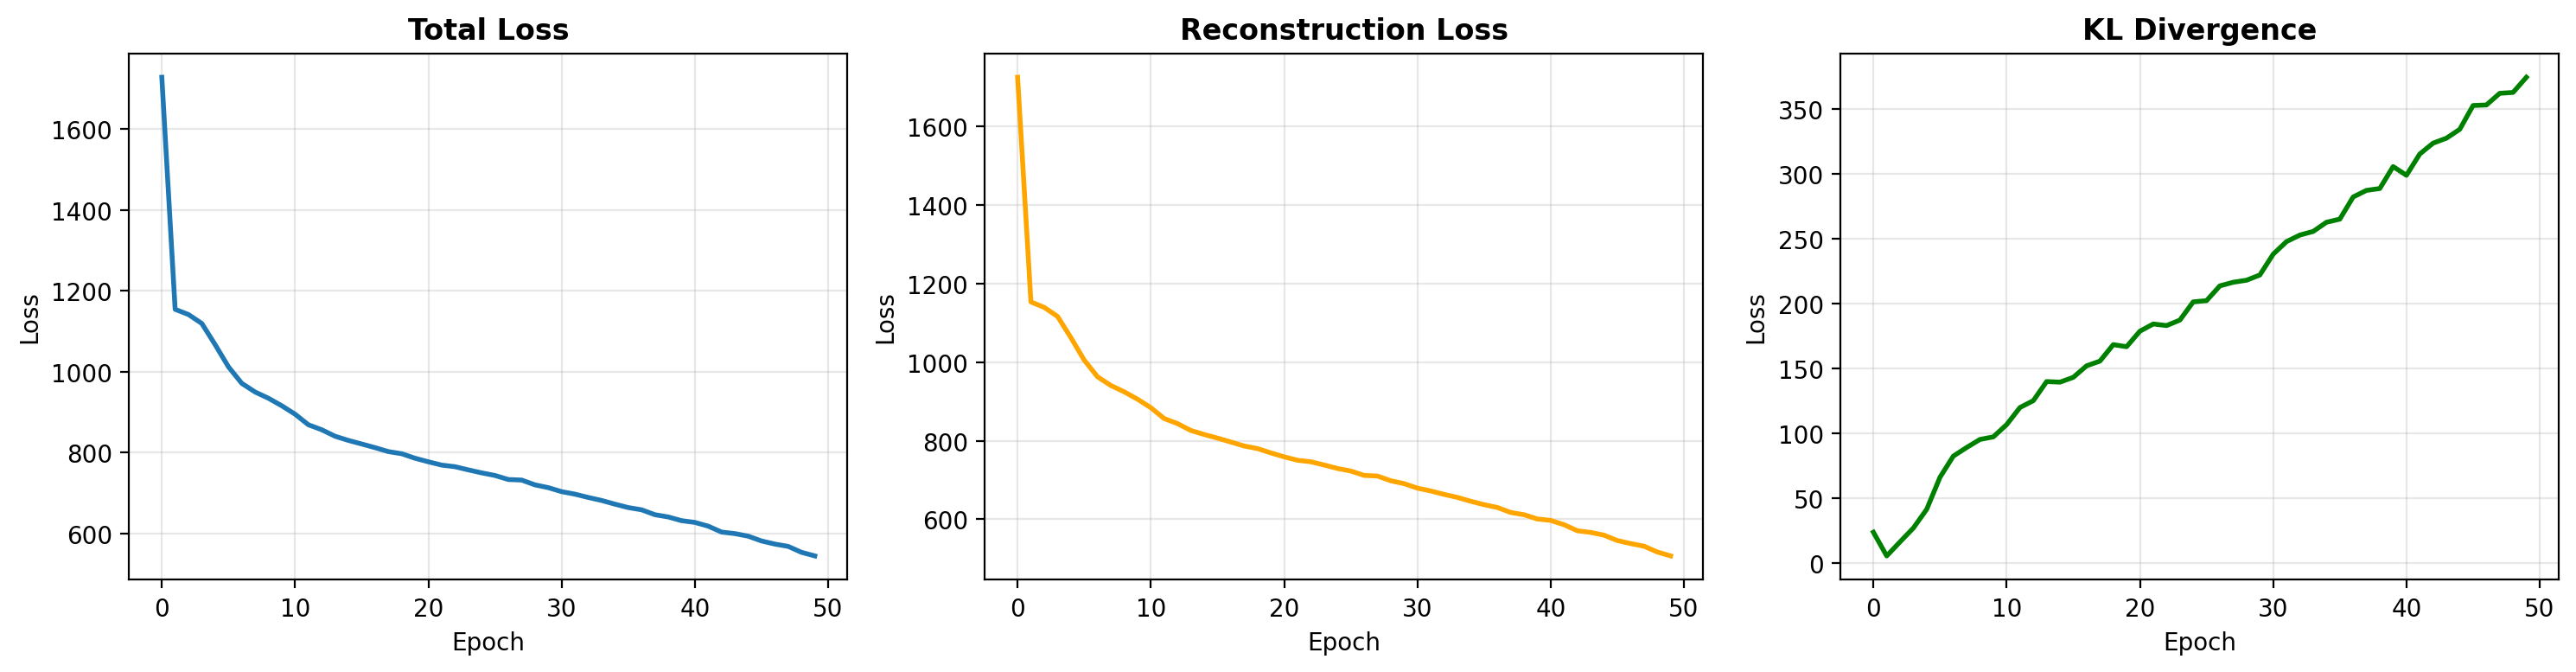

✓ Saved training curves to vae_training_curves.png

TESTING VAE RECONSTRUCTION


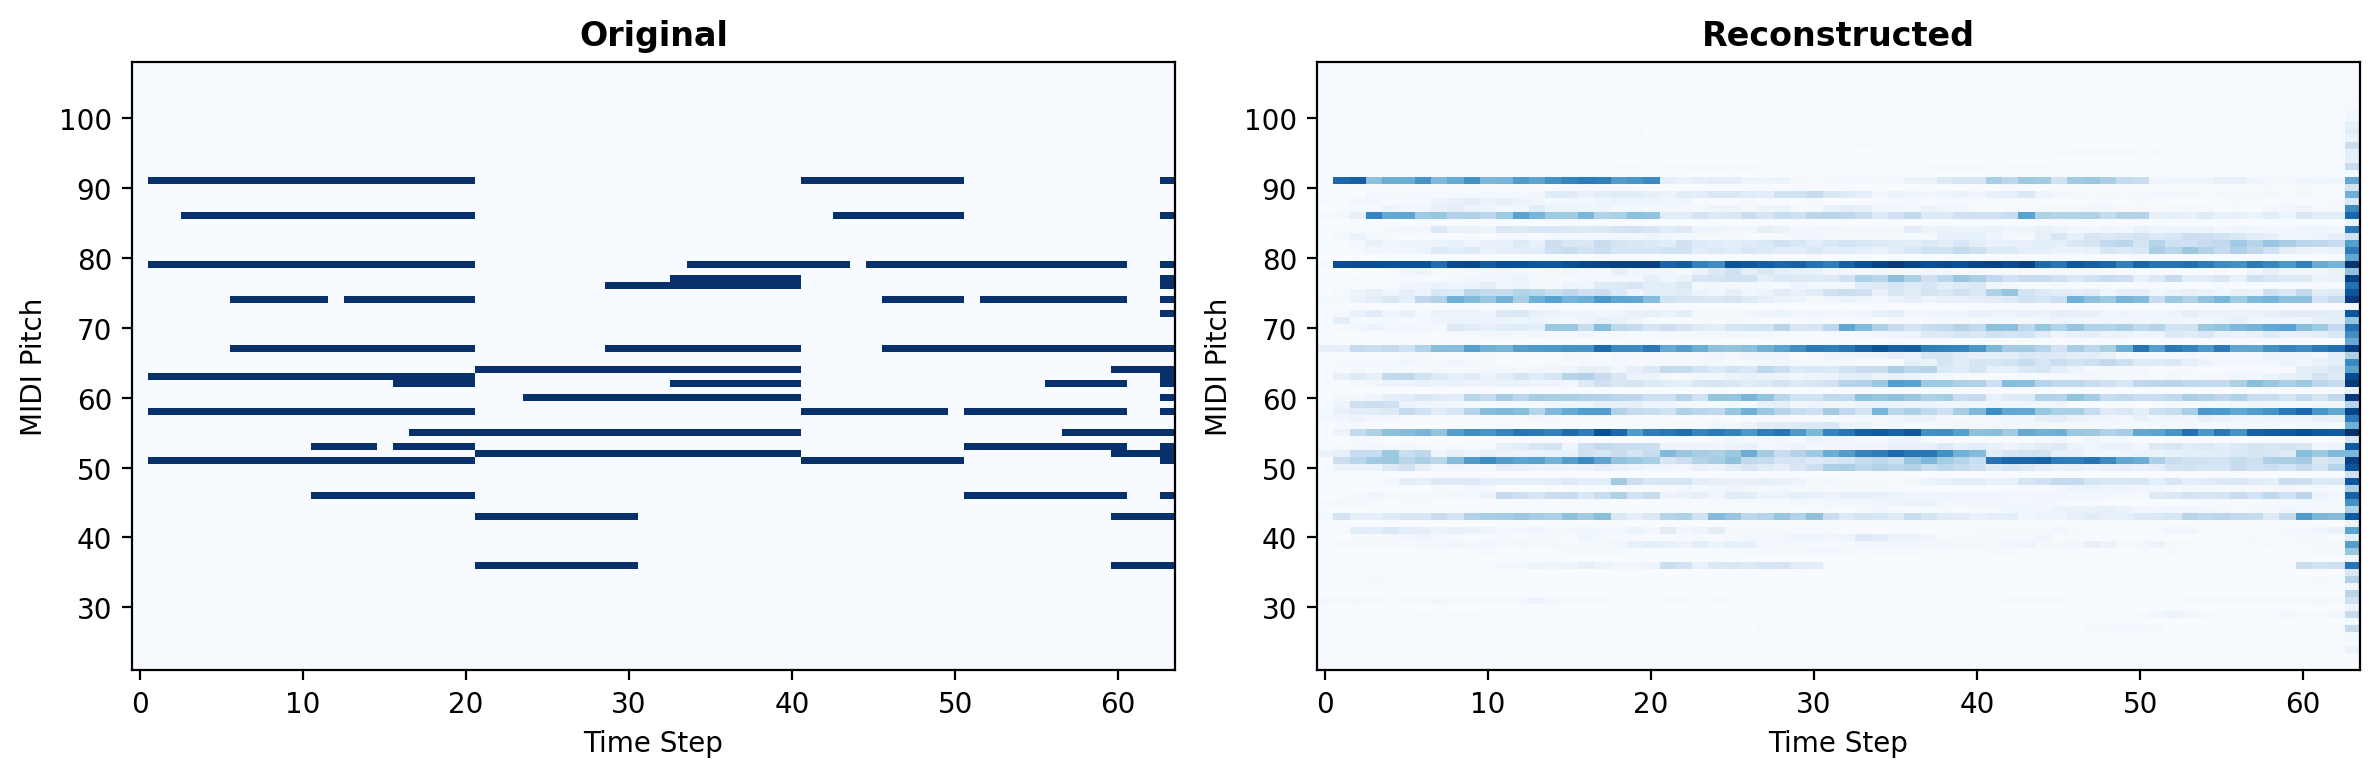

✓ Saved reconstruction comparison to vae_reconstruction.png

✓ STEP 3 COMPLETE - VAE TRAINED!

Next: Run Step 4 to build and train the GAN


In [ ]:
# Step 3: VAE Architecture & Training
# Run this after Step 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("=" * 60)
print("STEP 3: VAE ARCHITECTURE & TRAINING")
print("=" * 60)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

# Load preprocessed data
piano_rolls = np.load('piano_rolls.npy')
print(f"Loaded data: {piano_rolls.shape}")

# Configuration
LATENT_DIM = 512
HIDDEN_DIM = 1024
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-3
BETA = 0.1  # Weight for KL divergence (lower = more emphasis on reconstruction)

print(f"\nVAE Configuration:")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Beta (KL weight): {BETA}")

# Dataset class
class PianoRollDataset(Dataset):
    def __init__(self, piano_rolls):
        self.data = torch.FloatTensor(piano_rolls)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create dataset and dataloader
dataset = PianoRollDataset(piano_rolls)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"\nDataset size: {len(dataset)} samples")
print(f"Batches per epoch: {len(dataloader)}")

# VAE Model
class MusicVAE(nn.Module):
    def __init__(self, input_dim=64*128, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super(MusicVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        # Flatten: (B, 64, 128) -> (B, 8192)
        x = x.view(-1, self.input_dim)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder(z)
        # Reshape: (B, 8192) -> (B, 64, 128)
        return x.view(-1, 64, 128)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar, beta=BETA):
    # Reconstruction loss (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

# Initialize model
model = MusicVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n" + "=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Training loop
print("\n" + "=" * 60)
print("TRAINING VAE")
print("=" * 60)

train_losses = []
recon_losses = []
kl_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch in pbar:
        batch = batch.to(device)

        # Forward pass
        recon, mu, logvar = model(batch)
        loss, recon_loss, kl_loss = vae_loss(recon, batch, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track losses
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

        pbar.set_postfix({
            'Loss': f'{loss.item()/len(batch):.2f}',
            'Recon': f'{recon_loss.item()/len(batch):.2f}',
            'KL': f'{kl_loss.item()/len(batch):.2f}'
        })

    # Average losses
    avg_loss = epoch_loss / len(dataset)
    avg_recon = epoch_recon / len(dataset)
    avg_kl = epoch_kl / len(dataset)

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)

    print(f'Epoch {epoch+1}: Loss={avg_loss:.2f}, Recon={avg_recon:.2f}, KL={avg_kl:.2f}')

print("\n✓ Training complete!")

# Save model
torch.save(model.state_dict(), 'vae_model.pth')
print("✓ Model saved to vae_model.pth")

# Plot training curves
print("\n" + "=" * 60)
print("TRAINING CURVES")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, linewidth=2)
axes[0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.3)

axes[1].plot(recon_losses, color='orange', linewidth=2)
axes[1].set_title('Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(alpha=0.3)

axes[2].plot(kl_losses, color='green', linewidth=2)
axes[2].set_title('KL Divergence', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('vae_training_curves.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved training curves to vae_training_curves.png")

# Test reconstruction
print("\n" + "=" * 60)
print("TESTING VAE RECONSTRUCTION")
print("=" * 60)

model.eval()
with torch.no_grad():
    # Get a test sample
    test_sample = dataset[0].unsqueeze(0).to(device)
    recon, mu, logvar = model(test_sample)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(test_sample[0].cpu().numpy().T, aspect='auto', cmap='Blues', origin='lower')
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('MIDI Pitch')
    axes[0].set_ylim([21, 108])

    axes[1].imshow(recon[0].cpu().numpy().T, aspect='auto', cmap='Blues', origin='lower')
    axes[1].set_title('Reconstructed', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('MIDI Pitch')
    axes[1].set_ylim([21, 108])

    plt.tight_layout()
    plt.savefig('vae_reconstruction.png', dpi=100, bbox_inches='tight')
    plt.show()

print("✓ Saved reconstruction comparison to vae_reconstruction.png")

print("\n" + "=" * 60)
print("✓ STEP 3 COMPLETE - VAE TRAINED!")
print("=" * 60)
print("\nNext: Run Step 4 to build and train the GAN")

STEP 4: GAN WITH BALANCED TRAINING

Device: cpu
✓ VAE model loaded
Dataset size: 1071 samples

Extracting latent vectors from VAE...


100%|██████████| 17/17 [00:00<00:00, 37.08it/s]


✓ Extracted latent vectors: torch.Size([1071, 512])
✓ Normalized latent vectors
  Mean: -0.0000
  Std: 0.9995

GAN Configuration:
  Noise dimension: 128
  Latent dimension: 512
  Batch size: 64
  Epochs: 100
  Generator LR: 0.0003
  Discriminator LR: 1e-05
  Label smoothing (real): 0.9
  Label smoothing (fake): 0.1
  G updates per D update: 5

GENERATOR ARCHITECTURE
Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_featu

Epoch 1/100: 100%|██████████| 17/17 [00:01<00:00, 10.97it/s, G_Loss=0.436, D_Loss=2.020, D_Real=0.68, D_Fake=1.00]


Epoch 1: G_Loss=0.111, D_Loss=1.639, D_Real_Acc=0.64, D_Fake_Acc=0.03


Epoch 2/100: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s, G_Loss=0.368, D_Loss=2.139, D_Real=0.36, D_Fake=1.00]


Epoch 2: G_Loss=0.081, D_Loss=2.164, D_Real_Acc=0.50, D_Fake_Acc=0.00


Epoch 3/100: 100%|██████████| 17/17 [00:01<00:00, 11.00it/s, G_Loss=0.387, D_Loss=2.163, D_Real=0.21, D_Fake=1.00]


Epoch 3: G_Loss=0.077, D_Loss=2.239, D_Real_Acc=0.31, D_Fake_Acc=0.00


Epoch 4/100: 100%|██████████| 17/17 [00:02<00:00,  8.37it/s, G_Loss=0.378, D_Loss=2.092, D_Real=0.09, D_Fake=1.00]


Epoch 4: G_Loss=0.076, D_Loss=2.198, D_Real_Acc=0.15, D_Fake_Acc=0.00


Epoch 5/100: 100%|██████████| 17/17 [00:01<00:00,  8.88it/s, G_Loss=0.403, D_Loss=2.211, D_Real=0.06, D_Fake=0.98]


Epoch 5: G_Loss=0.078, D_Loss=2.215, D_Real_Acc=0.07, D_Fake_Acc=0.00


Epoch 6/100: 100%|██████████| 17/17 [00:01<00:00, 11.02it/s, G_Loss=0.393, D_Loss=2.138, D_Real=0.00, D_Fake=1.00]


Epoch 6: G_Loss=0.078, D_Loss=2.219, D_Real_Acc=0.03, D_Fake_Acc=0.00


Epoch 7/100: 100%|██████████| 17/17 [00:01<00:00, 11.45it/s, G_Loss=0.387, D_Loss=2.080, D_Real=0.00, D_Fake=1.00]


Epoch 7: G_Loss=0.079, D_Loss=2.186, D_Real_Acc=0.01, D_Fake_Acc=0.00


Epoch 8/100: 100%|██████████| 17/17 [00:01<00:00, 11.72it/s, G_Loss=0.410, D_Loss=2.107, D_Real=0.02, D_Fake=1.00]


Epoch 8: G_Loss=0.081, D_Loss=2.100, D_Real_Acc=0.00, D_Fake_Acc=0.01


Epoch 9/100: 100%|██████████| 17/17 [00:01<00:00, 11.38it/s, G_Loss=0.436, D_Loss=1.986, D_Real=0.00, D_Fake=1.00]


Epoch 9: G_Loss=0.083, D_Loss=2.056, D_Real_Acc=0.00, D_Fake_Acc=0.01


Epoch 10/100: 100%|██████████| 17/17 [00:01<00:00, 11.53it/s, G_Loss=0.412, D_Loss=1.978, D_Real=0.00, D_Fake=1.00]


Epoch 10: G_Loss=0.084, D_Loss=2.021, D_Real_Acc=0.00, D_Fake_Acc=0.00


Epoch 11/100: 100%|██████████| 17/17 [00:01<00:00, 11.18it/s, G_Loss=0.411, D_Loss=1.939, D_Real=0.00, D_Fake=0.98]


Epoch 11: G_Loss=0.085, D_Loss=2.016, D_Real_Acc=0.00, D_Fake_Acc=0.00


Epoch 12/100: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s, G_Loss=0.463, D_Loss=1.967, D_Real=0.00, D_Fake=1.00]


Epoch 12: G_Loss=0.089, D_Loss=1.950, D_Real_Acc=0.00, D_Fake_Acc=0.01


Epoch 13/100: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s, G_Loss=0.470, D_Loss=1.812, D_Real=0.00, D_Fake=1.00]


Epoch 13: G_Loss=0.091, D_Loss=1.880, D_Real_Acc=0.00, D_Fake_Acc=0.01


Epoch 14/100: 100%|██████████| 17/17 [00:01<00:00, 11.38it/s, G_Loss=0.469, D_Loss=1.821, D_Real=0.00, D_Fake=1.00]


Epoch 14: G_Loss=0.095, D_Loss=1.848, D_Real_Acc=0.00, D_Fake_Acc=0.02


Epoch 15/100: 100%|██████████| 17/17 [00:01<00:00, 11.29it/s, G_Loss=0.489, D_Loss=1.751, D_Real=0.00, D_Fake=0.96]


Epoch 15: G_Loss=0.095, D_Loss=1.828, D_Real_Acc=0.00, D_Fake_Acc=0.02


Epoch 16/100: 100%|██████████| 17/17 [00:01<00:00, 11.25it/s, G_Loss=0.495, D_Loss=1.792, D_Real=0.00, D_Fake=0.98]


Epoch 16: G_Loss=0.098, D_Loss=1.798, D_Real_Acc=0.00, D_Fake_Acc=0.02


Epoch 17/100: 100%|██████████| 17/17 [00:01<00:00, 11.38it/s, G_Loss=0.523, D_Loss=1.719, D_Real=0.00, D_Fake=1.00]


Epoch 17: G_Loss=0.101, D_Loss=1.753, D_Real_Acc=0.00, D_Fake_Acc=0.02


Epoch 18/100: 100%|██████████| 17/17 [00:01<00:00, 11.24it/s, G_Loss=0.495, D_Loss=1.735, D_Real=0.00, D_Fake=0.98]


Epoch 18: G_Loss=0.101, D_Loss=1.756, D_Real_Acc=0.00, D_Fake_Acc=0.02


Epoch 19/100: 100%|██████████| 17/17 [00:01<00:00, 11.30it/s, G_Loss=0.534, D_Loss=1.690, D_Real=0.00, D_Fake=0.96]


Epoch 19: G_Loss=0.104, D_Loss=1.745, D_Real_Acc=0.00, D_Fake_Acc=0.05


Epoch 20/100: 100%|██████████| 17/17 [00:02<00:00,  7.75it/s, G_Loss=0.551, D_Loss=1.676, D_Real=0.00, D_Fake=0.94]


Epoch 20: G_Loss=0.110, D_Loss=1.674, D_Real_Acc=0.00, D_Fake_Acc=0.08


Epoch 21/100: 100%|██████████| 17/17 [00:01<00:00,  9.69it/s, G_Loss=0.596, D_Loss=1.574, D_Real=0.00, D_Fake=0.83]


Epoch 21: G_Loss=0.117, D_Loss=1.606, D_Real_Acc=0.00, D_Fake_Acc=0.13


Epoch 22/100: 100%|██████████| 17/17 [00:01<00:00, 11.63it/s, G_Loss=0.657, D_Loss=1.489, D_Real=0.00, D_Fake=0.70]


Epoch 22: G_Loss=0.127, D_Loss=1.526, D_Real_Acc=0.00, D_Fake_Acc=0.24


Epoch 23/100: 100%|██████████| 17/17 [00:01<00:00, 11.52it/s, G_Loss=0.651, D_Loss=1.508, D_Real=0.00, D_Fake=0.66]


Epoch 23: G_Loss=0.132, D_Loss=1.480, D_Real_Acc=0.00, D_Fake_Acc=0.34


Epoch 24/100: 100%|██████████| 17/17 [00:01<00:00, 11.45it/s, G_Loss=0.678, D_Loss=1.477, D_Real=0.00, D_Fake=0.60]


Epoch 24: G_Loss=0.133, D_Loss=1.479, D_Real_Acc=0.00, D_Fake_Acc=0.34


Epoch 25/100: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s, G_Loss=0.692, D_Loss=1.425, D_Real=0.00, D_Fake=0.51]


Epoch 25: G_Loss=0.137, D_Loss=1.449, D_Real_Acc=0.00, D_Fake_Acc=0.45


Epoch 26/100: 100%|██████████| 17/17 [00:01<00:00, 11.30it/s, G_Loss=0.743, D_Loss=1.392, D_Real=0.00, D_Fake=0.32]


Epoch 26: G_Loss=0.144, D_Loss=1.411, D_Real_Acc=0.00, D_Fake_Acc=0.58


Epoch 27/100: 100%|██████████| 17/17 [00:01<00:00, 10.51it/s, G_Loss=0.724, D_Loss=1.394, D_Real=0.00, D_Fake=0.36]


Epoch 27: G_Loss=0.146, D_Loss=1.389, D_Real_Acc=0.00, D_Fake_Acc=0.68


Epoch 28/100: 100%|██████████| 17/17 [00:02<00:00,  7.37it/s, G_Loss=0.761, D_Loss=1.389, D_Real=0.00, D_Fake=0.17]


Epoch 28: G_Loss=0.147, D_Loss=1.397, D_Real_Acc=0.00, D_Fake_Acc=0.69


Epoch 29/100: 100%|██████████| 17/17 [00:01<00:00, 10.33it/s, G_Loss=0.763, D_Loss=1.376, D_Real=0.00, D_Fake=0.21]


Epoch 29: G_Loss=0.149, D_Loss=1.379, D_Real_Acc=0.00, D_Fake_Acc=0.75


Epoch 30/100: 100%|██████████| 17/17 [00:01<00:00, 11.30it/s, G_Loss=0.754, D_Loss=1.378, D_Real=0.00, D_Fake=0.11]


Epoch 30: G_Loss=0.151, D_Loss=1.378, D_Real_Acc=0.00, D_Fake_Acc=0.81


Epoch 31/100: 100%|██████████| 17/17 [00:01<00:00, 11.50it/s, G_Loss=0.753, D_Loss=1.369, D_Real=0.00, D_Fake=0.06]


Epoch 31: G_Loss=0.151, D_Loss=1.368, D_Real_Acc=0.00, D_Fake_Acc=0.89


Epoch 32/100: 100%|██████████| 17/17 [00:01<00:00, 11.58it/s, G_Loss=0.740, D_Loss=1.383, D_Real=0.00, D_Fake=0.17]


Epoch 32: G_Loss=0.148, D_Loss=1.380, D_Real_Acc=0.00, D_Fake_Acc=0.86


Epoch 33/100: 100%|██████████| 17/17 [00:01<00:00, 11.37it/s, G_Loss=0.700, D_Loss=1.408, D_Real=0.00, D_Fake=0.36]


Epoch 33: G_Loss=0.143, D_Loss=1.406, D_Real_Acc=0.00, D_Fake_Acc=0.71


Epoch 34/100: 100%|██████████| 17/17 [00:01<00:00, 11.26it/s, G_Loss=0.717, D_Loss=1.409, D_Real=0.00, D_Fake=0.30]


Epoch 34: G_Loss=0.142, D_Loss=1.412, D_Real_Acc=0.00, D_Fake_Acc=0.68


Epoch 35/100: 100%|██████████| 17/17 [00:01<00:00, 10.38it/s, G_Loss=0.710, D_Loss=1.423, D_Real=0.00, D_Fake=0.32]


Epoch 35: G_Loss=0.141, D_Loss=1.417, D_Real_Acc=0.00, D_Fake_Acc=0.65


Epoch 36/100: 100%|██████████| 17/17 [00:02<00:00,  7.66it/s, G_Loss=0.708, D_Loss=1.427, D_Real=0.00, D_Fake=0.34]


Epoch 36: G_Loss=0.141, D_Loss=1.420, D_Real_Acc=0.00, D_Fake_Acc=0.63


Epoch 37/100: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, G_Loss=0.703, D_Loss=1.434, D_Real=0.00, D_Fake=0.51]


Epoch 37: G_Loss=0.141, D_Loss=1.422, D_Real_Acc=0.00, D_Fake_Acc=0.62


Epoch 38/100: 100%|██████████| 17/17 [00:01<00:00, 11.54it/s, G_Loss=0.701, D_Loss=1.422, D_Real=0.00, D_Fake=0.34]


Epoch 38: G_Loss=0.141, D_Loss=1.424, D_Real_Acc=0.00, D_Fake_Acc=0.59


Epoch 39/100: 100%|██████████| 17/17 [00:01<00:00, 11.27it/s, G_Loss=0.703, D_Loss=1.428, D_Real=0.00, D_Fake=0.47]


Epoch 39: G_Loss=0.139, D_Loss=1.429, D_Real_Acc=0.00, D_Fake_Acc=0.50


Epoch 40/100: 100%|██████████| 17/17 [00:01<00:00, 11.39it/s, G_Loss=0.702, D_Loss=1.431, D_Real=0.00, D_Fake=0.47]


Epoch 40: G_Loss=0.140, D_Loss=1.428, D_Real_Acc=0.00, D_Fake_Acc=0.49


Epoch 41/100: 100%|██████████| 17/17 [00:01<00:00, 11.36it/s, G_Loss=0.707, D_Loss=1.427, D_Real=0.00, D_Fake=0.49]


Epoch 41: G_Loss=0.140, D_Loss=1.424, D_Real_Acc=0.00, D_Fake_Acc=0.56


Epoch 42/100: 100%|██████████| 17/17 [00:01<00:00, 11.46it/s, G_Loss=0.699, D_Loss=1.420, D_Real=0.00, D_Fake=0.34]


Epoch 42: G_Loss=0.140, D_Loss=1.425, D_Real_Acc=0.00, D_Fake_Acc=0.58


Epoch 43/100: 100%|██████████| 17/17 [00:01<00:00, 10.09it/s, G_Loss=0.699, D_Loss=1.431, D_Real=0.00, D_Fake=0.32]


Epoch 43: G_Loss=0.140, D_Loss=1.426, D_Real_Acc=0.00, D_Fake_Acc=0.60


Epoch 44/100: 100%|██████████| 17/17 [00:02<00:00,  7.71it/s, G_Loss=0.704, D_Loss=1.419, D_Real=0.00, D_Fake=0.28]


Epoch 44: G_Loss=0.142, D_Loss=1.419, D_Real_Acc=0.00, D_Fake_Acc=0.65


Epoch 45/100: 100%|██████████| 17/17 [00:01<00:00, 11.36it/s, G_Loss=0.720, D_Loss=1.407, D_Real=0.00, D_Fake=0.23]


Epoch 45: G_Loss=0.143, D_Loss=1.415, D_Real_Acc=0.00, D_Fake_Acc=0.72


Epoch 46/100: 100%|██████████| 17/17 [00:01<00:00, 11.31it/s, G_Loss=0.717, D_Loss=1.416, D_Real=0.00, D_Fake=0.15]


Epoch 46: G_Loss=0.143, D_Loss=1.409, D_Real_Acc=0.00, D_Fake_Acc=0.79


Epoch 47/100: 100%|██████████| 17/17 [00:01<00:00, 11.28it/s, G_Loss=0.716, D_Loss=1.404, D_Real=0.00, D_Fake=0.23]


Epoch 47: G_Loss=0.144, D_Loss=1.406, D_Real_Acc=0.00, D_Fake_Acc=0.83


Epoch 48/100: 100%|██████████| 17/17 [00:01<00:00, 11.37it/s, G_Loss=0.722, D_Loss=1.407, D_Real=0.00, D_Fake=0.15]


Epoch 48: G_Loss=0.144, D_Loss=1.404, D_Real_Acc=0.00, D_Fake_Acc=0.85


Epoch 49/100: 100%|██████████| 17/17 [00:01<00:00, 11.31it/s, G_Loss=0.731, D_Loss=1.404, D_Real=0.00, D_Fake=0.11]


Epoch 49: G_Loss=0.144, D_Loss=1.403, D_Real_Acc=0.00, D_Fake_Acc=0.86


Epoch 50/100: 100%|██████████| 17/17 [00:01<00:00, 11.29it/s, G_Loss=0.734, D_Loss=1.385, D_Real=0.00, D_Fake=0.11]


Epoch 50: G_Loss=0.146, D_Loss=1.394, D_Real_Acc=0.00, D_Fake_Acc=0.91


Epoch 51/100: 100%|██████████| 17/17 [00:01<00:00,  9.61it/s, G_Loss=0.733, D_Loss=1.388, D_Real=0.00, D_Fake=0.06]


Epoch 51: G_Loss=0.147, D_Loss=1.392, D_Real_Acc=0.00, D_Fake_Acc=0.92


Epoch 52/100: 100%|██████████| 17/17 [00:02<00:00,  7.89it/s, G_Loss=0.737, D_Loss=1.394, D_Real=0.00, D_Fake=0.02]


Epoch 52: G_Loss=0.147, D_Loss=1.392, D_Real_Acc=0.00, D_Fake_Acc=0.93


Epoch 53/100: 100%|██████████| 17/17 [00:01<00:00, 11.74it/s, G_Loss=0.735, D_Loss=1.396, D_Real=0.00, D_Fake=0.00]


Epoch 53: G_Loss=0.147, D_Loss=1.389, D_Real_Acc=0.00, D_Fake_Acc=0.97


Epoch 54/100: 100%|██████████| 17/17 [00:01<00:00, 11.24it/s, G_Loss=0.731, D_Loss=1.408, D_Real=0.00, D_Fake=0.04]


Epoch 54: G_Loss=0.146, D_Loss=1.395, D_Real_Acc=0.00, D_Fake_Acc=0.95


Epoch 55/100: 100%|██████████| 17/17 [00:01<00:00, 11.44it/s, G_Loss=0.715, D_Loss=1.409, D_Real=0.00, D_Fake=0.17]


Epoch 55: G_Loss=0.144, D_Loss=1.404, D_Real_Acc=0.00, D_Fake_Acc=0.93


Epoch 56/100: 100%|██████████| 17/17 [00:01<00:00, 11.51it/s, G_Loss=0.714, D_Loss=1.413, D_Real=0.00, D_Fake=0.13]


Epoch 56: G_Loss=0.143, D_Loss=1.410, D_Real_Acc=0.00, D_Fake_Acc=0.89


Epoch 57/100: 100%|██████████| 17/17 [00:01<00:00, 11.57it/s, G_Loss=0.700, D_Loss=1.422, D_Real=0.00, D_Fake=0.28]


Epoch 57: G_Loss=0.141, D_Loss=1.417, D_Real_Acc=0.00, D_Fake_Acc=0.79


Epoch 58/100: 100%|██████████| 17/17 [00:01<00:00, 11.50it/s, G_Loss=0.694, D_Loss=1.421, D_Real=0.00, D_Fake=0.60]


Epoch 58: G_Loss=0.140, D_Loss=1.424, D_Real_Acc=0.00, D_Fake_Acc=0.70


Epoch 59/100: 100%|██████████| 17/17 [00:01<00:00,  9.77it/s, G_Loss=0.692, D_Loss=1.428, D_Real=0.00, D_Fake=0.60]


Epoch 59: G_Loss=0.139, D_Loss=1.430, D_Real_Acc=0.00, D_Fake_Acc=0.54


Epoch 60/100: 100%|██████████| 17/17 [00:02<00:00,  7.79it/s, G_Loss=0.691, D_Loss=1.432, D_Real=0.00, D_Fake=0.51]


Epoch 60: G_Loss=0.139, D_Loss=1.433, D_Real_Acc=0.00, D_Fake_Acc=0.49


Epoch 61/100: 100%|██████████| 17/17 [00:01<00:00, 11.05it/s, G_Loss=0.690, D_Loss=1.437, D_Real=0.00, D_Fake=0.60]


Epoch 61: G_Loss=0.138, D_Loss=1.436, D_Real_Acc=0.00, D_Fake_Acc=0.44


Epoch 62/100: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s, G_Loss=0.687, D_Loss=1.443, D_Real=0.00, D_Fake=0.62]


Epoch 62: G_Loss=0.138, D_Loss=1.439, D_Real_Acc=0.00, D_Fake_Acc=0.36


Epoch 63/100: 100%|██████████| 17/17 [00:01<00:00, 11.15it/s, G_Loss=0.691, D_Loss=1.432, D_Real=0.00, D_Fake=0.64]


Epoch 63: G_Loss=0.138, D_Loss=1.438, D_Real_Acc=0.00, D_Fake_Acc=0.31


Epoch 64/100: 100%|██████████| 17/17 [00:01<00:00, 11.21it/s, G_Loss=0.687, D_Loss=1.434, D_Real=0.00, D_Fake=0.74]


Epoch 64: G_Loss=0.138, D_Loss=1.438, D_Real_Acc=0.00, D_Fake_Acc=0.34


Epoch 65/100: 100%|██████████| 17/17 [00:01<00:00, 11.35it/s, G_Loss=0.691, D_Loss=1.432, D_Real=0.00, D_Fake=0.53]


Epoch 65: G_Loss=0.138, D_Loss=1.435, D_Real_Acc=0.00, D_Fake_Acc=0.42


Epoch 66/100: 100%|██████████| 17/17 [00:01<00:00, 11.35it/s, G_Loss=0.700, D_Loss=1.428, D_Real=0.00, D_Fake=0.28]


Epoch 66: G_Loss=0.139, D_Loss=1.428, D_Real_Acc=0.00, D_Fake_Acc=0.62


Epoch 67/100: 100%|██████████| 17/17 [00:01<00:00,  9.20it/s, G_Loss=0.706, D_Loss=1.417, D_Real=0.00, D_Fake=0.17]


Epoch 67: G_Loss=0.141, D_Loss=1.421, D_Real_Acc=0.00, D_Fake_Acc=0.81


Epoch 68/100: 100%|██████████| 17/17 [00:02<00:00,  8.19it/s, G_Loss=0.713, D_Loss=1.406, D_Real=0.00, D_Fake=0.02]


Epoch 68: G_Loss=0.143, D_Loss=1.412, D_Real_Acc=0.00, D_Fake_Acc=0.95


Epoch 69/100: 100%|██████████| 17/17 [00:01<00:00, 11.62it/s, G_Loss=0.724, D_Loss=1.408, D_Real=0.00, D_Fake=0.00]


Epoch 69: G_Loss=0.144, D_Loss=1.405, D_Real_Acc=0.00, D_Fake_Acc=0.99


Epoch 70/100: 100%|██████████| 17/17 [00:01<00:00, 11.65it/s, G_Loss=0.731, D_Loss=1.391, D_Real=0.00, D_Fake=0.00]


Epoch 70: G_Loss=0.145, D_Loss=1.399, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 71/100: 100%|██████████| 17/17 [00:01<00:00, 11.46it/s, G_Loss=0.735, D_Loss=1.395, D_Real=0.00, D_Fake=0.00]


Epoch 71: G_Loss=0.146, D_Loss=1.393, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 72/100: 100%|██████████| 17/17 [00:01<00:00, 11.53it/s, G_Loss=0.735, D_Loss=1.394, D_Real=0.00, D_Fake=0.00]


Epoch 72: G_Loss=0.146, D_Loss=1.393, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 73/100: 100%|██████████| 17/17 [00:01<00:00, 11.52it/s, G_Loss=0.727, D_Loss=1.392, D_Real=0.00, D_Fake=0.00]


Epoch 73: G_Loss=0.146, D_Loss=1.394, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 74/100: 100%|██████████| 17/17 [00:01<00:00, 11.70it/s, G_Loss=0.723, D_Loss=1.402, D_Real=0.00, D_Fake=0.00]


Epoch 74: G_Loss=0.145, D_Loss=1.398, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 75/100: 100%|██████████| 17/17 [00:01<00:00,  9.26it/s, G_Loss=0.716, D_Loss=1.408, D_Real=0.00, D_Fake=0.00]


Epoch 75: G_Loss=0.144, D_Loss=1.405, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 76/100: 100%|██████████| 17/17 [00:02<00:00,  8.30it/s, G_Loss=0.706, D_Loss=1.411, D_Real=0.00, D_Fake=0.00]


Epoch 76: G_Loss=0.142, D_Loss=1.412, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 77/100: 100%|██████████| 17/17 [00:01<00:00, 11.56it/s, G_Loss=0.702, D_Loss=1.423, D_Real=0.00, D_Fake=0.04]


Epoch 77: G_Loss=0.141, D_Loss=1.420, D_Real_Acc=0.00, D_Fake_Acc=0.96


Epoch 78/100: 100%|██████████| 17/17 [00:01<00:00, 11.50it/s, G_Loss=0.698, D_Loss=1.428, D_Real=0.00, D_Fake=0.19]


Epoch 78: G_Loss=0.140, D_Loss=1.425, D_Real_Acc=0.00, D_Fake_Acc=0.84


Epoch 79/100: 100%|██████████| 17/17 [00:01<00:00, 11.65it/s, G_Loss=0.693, D_Loss=1.434, D_Real=0.00, D_Fake=0.60]


Epoch 79: G_Loss=0.139, D_Loss=1.430, D_Real_Acc=0.00, D_Fake_Acc=0.64


Epoch 80/100: 100%|██████████| 17/17 [00:01<00:00, 11.70it/s, G_Loss=0.693, D_Loss=1.434, D_Real=0.00, D_Fake=0.60]


Epoch 80: G_Loss=0.138, D_Loss=1.433, D_Real_Acc=0.00, D_Fake_Acc=0.42


Epoch 81/100: 100%|██████████| 17/17 [00:01<00:00, 11.47it/s, G_Loss=0.688, D_Loss=1.435, D_Real=0.00, D_Fake=0.81]


Epoch 81: G_Loss=0.138, D_Loss=1.434, D_Real_Acc=0.00, D_Fake_Acc=0.26


Epoch 82/100: 100%|██████████| 17/17 [00:01<00:00, 11.69it/s, G_Loss=0.686, D_Loss=1.439, D_Real=0.00, D_Fake=0.89]


Epoch 82: G_Loss=0.137, D_Loss=1.436, D_Real_Acc=0.00, D_Fake_Acc=0.17


Epoch 83/100: 100%|██████████| 17/17 [00:01<00:00,  9.53it/s, G_Loss=0.686, D_Loss=1.437, D_Real=0.00, D_Fake=0.91]


Epoch 83: G_Loss=0.137, D_Loss=1.436, D_Real_Acc=0.00, D_Fake_Acc=0.15


Epoch 84/100: 100%|██████████| 17/17 [00:02<00:00,  7.91it/s, G_Loss=0.687, D_Loss=1.434, D_Real=0.00, D_Fake=0.85]


Epoch 84: G_Loss=0.137, D_Loss=1.436, D_Real_Acc=0.00, D_Fake_Acc=0.16


Epoch 85/100: 100%|██████████| 17/17 [00:01<00:00, 11.37it/s, G_Loss=0.687, D_Loss=1.437, D_Real=0.00, D_Fake=0.87]


Epoch 85: G_Loss=0.137, D_Loss=1.436, D_Real_Acc=0.00, D_Fake_Acc=0.19


Epoch 86/100: 100%|██████████| 17/17 [00:01<00:00, 11.24it/s, G_Loss=0.689, D_Loss=1.434, D_Real=0.00, D_Fake=0.60]


Epoch 86: G_Loss=0.138, D_Loss=1.433, D_Real_Acc=0.00, D_Fake_Acc=0.28


Epoch 87/100: 100%|██████████| 17/17 [00:01<00:00, 11.30it/s, G_Loss=0.695, D_Loss=1.425, D_Real=0.00, D_Fake=0.47]


Epoch 87: G_Loss=0.138, D_Loss=1.429, D_Real_Acc=0.00, D_Fake_Acc=0.43


Epoch 88/100: 100%|██████████| 17/17 [00:01<00:00, 11.29it/s, G_Loss=0.699, D_Loss=1.419, D_Real=0.00, D_Fake=0.38]


Epoch 88: G_Loss=0.139, D_Loss=1.424, D_Real_Acc=0.00, D_Fake_Acc=0.59


Epoch 89/100: 100%|██████████| 17/17 [00:01<00:00, 11.40it/s, G_Loss=0.705, D_Loss=1.415, D_Real=0.00, D_Fake=0.30]


Epoch 89: G_Loss=0.140, D_Loss=1.418, D_Real_Acc=0.00, D_Fake_Acc=0.74


Epoch 90/100: 100%|██████████| 17/17 [00:01<00:00, 11.32it/s, G_Loss=0.711, D_Loss=1.409, D_Real=0.00, D_Fake=0.09]


Epoch 90: G_Loss=0.141, D_Loss=1.412, D_Real_Acc=0.00, D_Fake_Acc=0.86


Epoch 91/100: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s, G_Loss=0.712, D_Loss=1.407, D_Real=0.00, D_Fake=0.00]


Epoch 91: G_Loss=0.142, D_Loss=1.408, D_Real_Acc=0.00, D_Fake_Acc=0.95


Epoch 92/100: 100%|██████████| 17/17 [00:02<00:00,  8.26it/s, G_Loss=0.714, D_Loss=1.404, D_Real=0.00, D_Fake=0.00]


Epoch 92: G_Loss=0.143, D_Loss=1.404, D_Real_Acc=0.00, D_Fake_Acc=0.99


Epoch 93/100: 100%|██████████| 17/17 [00:01<00:00, 11.24it/s, G_Loss=0.716, D_Loss=1.401, D_Real=0.00, D_Fake=0.00]


Epoch 93: G_Loss=0.143, D_Loss=1.403, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 94/100: 100%|██████████| 17/17 [00:01<00:00, 11.52it/s, G_Loss=0.715, D_Loss=1.403, D_Real=0.00, D_Fake=0.00]


Epoch 94: G_Loss=0.143, D_Loss=1.402, D_Real_Acc=0.00, D_Fake_Acc=1.00


Epoch 95/100: 100%|██████████| 17/17 [00:01<00:00, 11.34it/s, G_Loss=0.710, D_Loss=1.405, D_Real=0.00, D_Fake=0.02]


Epoch 95: G_Loss=0.143, D_Loss=1.405, D_Real_Acc=0.00, D_Fake_Acc=0.99


Epoch 96/100: 100%|██████████| 17/17 [00:01<00:00, 11.39it/s, G_Loss=0.710, D_Loss=1.407, D_Real=0.00, D_Fake=0.02]


Epoch 96: G_Loss=0.142, D_Loss=1.409, D_Real_Acc=0.00, D_Fake_Acc=0.98


Epoch 97/100: 100%|██████████| 17/17 [00:01<00:00, 11.40it/s, G_Loss=0.706, D_Loss=1.413, D_Real=0.00, D_Fake=0.00]


Epoch 97: G_Loss=0.142, D_Loss=1.410, D_Real_Acc=0.00, D_Fake_Acc=0.97


Epoch 98/100: 100%|██████████| 17/17 [00:01<00:00, 11.17it/s, G_Loss=0.704, D_Loss=1.414, D_Real=0.00, D_Fake=0.13]


Epoch 98: G_Loss=0.141, D_Loss=1.413, D_Real_Acc=0.00, D_Fake_Acc=0.94


Epoch 99/100: 100%|██████████| 17/17 [00:02<00:00,  8.48it/s, G_Loss=0.702, D_Loss=1.419, D_Real=0.00, D_Fake=0.09]


Epoch 99: G_Loss=0.140, D_Loss=1.416, D_Real_Acc=0.00, D_Fake_Acc=0.90


Epoch 100/100: 100%|██████████| 17/17 [00:01<00:00,  8.51it/s, G_Loss=0.700, D_Loss=1.423, D_Real=0.00, D_Fake=0.17]


Epoch 100: G_Loss=0.140, D_Loss=1.419, D_Real_Acc=0.00, D_Fake_Acc=0.88

✓ GAN Training complete!
✓ Models saved

GAN TRAINING CURVES


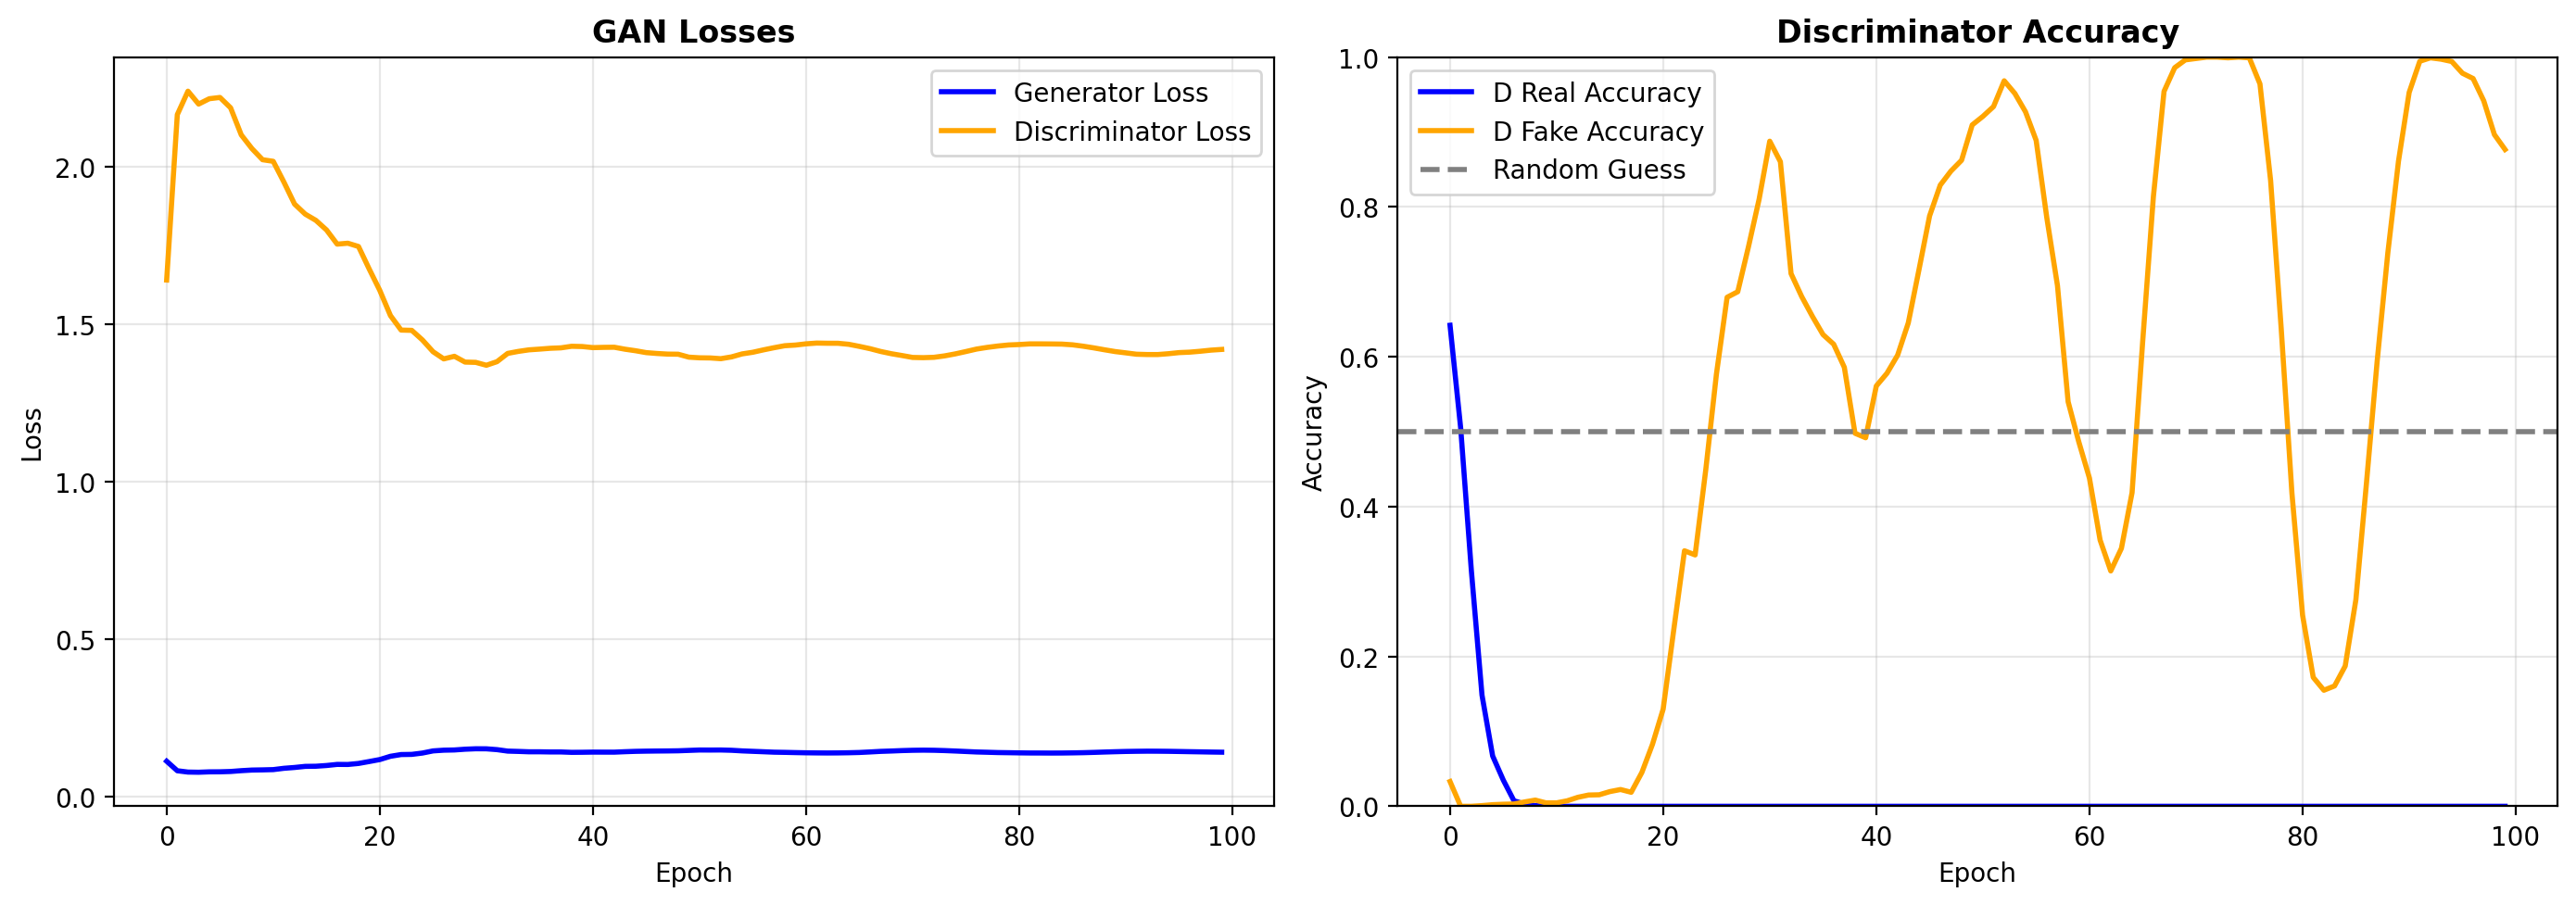

✓ Saved training curves

✓ STEP 4 COMPLETE


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("=" * 60)
print("STEP 4: GAN WITH BALANCED TRAINING")
print("=" * 60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

class MusicVAE(nn.Module):
    def __init__(self, input_dim=64*128, hidden_dim=1024, latent_dim=512):
        super(MusicVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = x.view(-1, self.input_dim)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x.view(-1, 64, 128)

vae = MusicVAE().to(device)
vae.load_state_dict(torch.load('vae_model.pth', map_location=device))
vae.eval()
print("✓ VAE model loaded")

piano_rolls = np.load('piano_rolls.npy')
dataset = torch.FloatTensor(piano_rolls)

print(f"Dataset size: {len(dataset)} samples")

print("\nExtracting latent vectors from VAE...")
latent_vectors = []
batch_size = 64

with torch.no_grad():
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size].to(device)
        mu, _ = vae.encode(batch)
        latent_vectors.append(mu.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)
print(f"✓ Extracted latent vectors: {latent_vectors.shape}")

latent_mean = latent_vectors.mean(dim=0)
latent_std = latent_vectors.std(dim=0)
latent_vectors_normalized = (latent_vectors - latent_mean) / (latent_std + 1e-8)

print(f"✓ Normalized latent vectors")
print(f"  Mean: {latent_vectors_normalized.mean():.4f}")
print(f"  Std: {latent_vectors_normalized.std():.4f}")

torch.save({'mean': latent_mean, 'std': latent_std}, 'latent_stats.pth')

NOISE_DIM = 128
LATENT_DIM = 512
HIDDEN_DIM = 512
BATCH_SIZE = 64
EPOCHS = 100
LR_G = 3e-4
LR_D = 1e-5
LABEL_SMOOTH_REAL = 0.9
LABEL_SMOOTH_FAKE = 0.1
N_CRITIC = 1
N_GEN = 5

print(f"\nGAN Configuration:")
print(f"  Noise dimension: {NOISE_DIM}")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Generator LR: {LR_G}")
print(f"  Discriminator LR: {LR_D}")
print(f"  Label smoothing (real): {LABEL_SMOOTH_REAL}")
print(f"  Label smoothing (fake): {LABEL_SMOOTH_FAKE}")
print(f"  G updates per D update: {N_GEN}")

class Generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, noise):
        return self.model(noise)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )

    def forward(self, latent):
        return self.model(latent)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

criterion = nn.BCELoss()

print("\n" + "=" * 60)
print("GENERATOR ARCHITECTURE")
print("=" * 60)
print(generator)
print(f"Parameters: {sum(p.numel() for p in generator.parameters()):,}")

print("\n" + "=" * 60)
print("DISCRIMINATOR ARCHITECTURE")
print("=" * 60)
print(discriminator)
print(f"Parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

latent_dataset = TensorDataset(latent_vectors_normalized)
latent_loader = DataLoader(latent_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print("\n" + "=" * 60)
print("TRAINING GAN")
print("=" * 60)

g_losses = []
d_losses = []
d_real_accs = []
d_fake_accs = []

for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()

    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_d_real_acc = 0
    epoch_d_fake_acc = 0

    pbar = tqdm(latent_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')

    for batch_idx, (real_latent,) in enumerate(pbar):
        batch_size_current = real_latent.size(0)
        real_latent = real_latent.to(device)

        real_labels = torch.empty(batch_size_current, 1).uniform_(LABEL_SMOOTH_REAL - 0.1, LABEL_SMOOTH_REAL + 0.1).to(device)
        fake_labels = torch.empty(batch_size_current, 1).uniform_(0.0, LABEL_SMOOTH_FAKE).to(device)

        if batch_idx % N_CRITIC == 0:
            optimizer_D.zero_grad()

            real_output = discriminator(real_latent)
            d_real_loss = criterion(real_output, real_labels)

            noise = torch.randn(batch_size_current, NOISE_DIM).to(device)
            fake_latent = generator(noise)
            fake_output = discriminator(fake_latent.detach())
            d_fake_loss = criterion(fake_output, fake_labels)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()

            epoch_d_loss += d_loss.item()
            epoch_d_real_acc += (real_output > 0.5).float().mean().item()
            epoch_d_fake_acc += (fake_output < 0.5).float().mean().item()

        for _ in range(N_GEN):
            optimizer_G.zero_grad()

            noise = torch.randn(batch_size_current, NOISE_DIM).to(device)
            fake_latent = generator(noise)
            fake_output = discriminator(fake_latent)

            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            optimizer_G.step()

        epoch_g_loss += g_loss.item()

        pbar.set_postfix({
            'G_Loss': f'{g_loss.item():.3f}',
            'D_Loss': f'{d_loss.item():.3f}',
            'D_Real': f'{(real_output > 0.5).float().mean().item():.2f}',
            'D_Fake': f'{(fake_output > 0.5).float().mean().item():.2f}'
        })

    num_batches = len(latent_loader)
    g_losses.append(epoch_g_loss / (num_batches * N_GEN))
    d_losses.append(epoch_d_loss / (num_batches // N_CRITIC))
    d_real_accs.append(epoch_d_real_acc / (num_batches // N_CRITIC))
    d_fake_accs.append(epoch_d_fake_acc / (num_batches // N_CRITIC))

    print(f'Epoch {epoch+1}: G_Loss={g_losses[-1]:.3f}, D_Loss={d_losses[-1]:.3f}, '
          f'D_Real_Acc={d_real_accs[-1]:.2f}, D_Fake_Acc={d_fake_accs[-1]:.2f}')

print("\n✓ GAN Training complete!")

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("✓ Models saved")

print("\n" + "=" * 60)
print("GAN TRAINING CURVES")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(g_losses, label='Generator Loss', linewidth=2, color='blue')
axes[0].plot(d_losses, label='Discriminator Loss', linewidth=2, color='orange')
axes[0].set_title('GAN Losses', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(d_real_accs, label='D Real Accuracy', linewidth=2, color='blue')
axes[1].plot(d_fake_accs, label='D Fake Accuracy', linewidth=2, color='orange')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random Guess', linewidth=2)
axes[1].set_title('Discriminator Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('gan_training_curves.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved training curves")
print("\n" + "=" * 60)
print("✓ STEP 4 COMPLETE")
print("=" * 60)

Installing audio conversion dependencies...
STEP 5: GENERATING MUSIC WITH GAN + VAE

Device: cpu

Loading trained models...
✓ VAE loaded
✓ Generator loaded
✓ Latent normalization stats loaded

GENERATING MUSIC SAMPLES

Generating 8 samples with temperature=1.0...
✓ Generated 8 piano rolls

VISUALIZING GENERATED SAMPLES


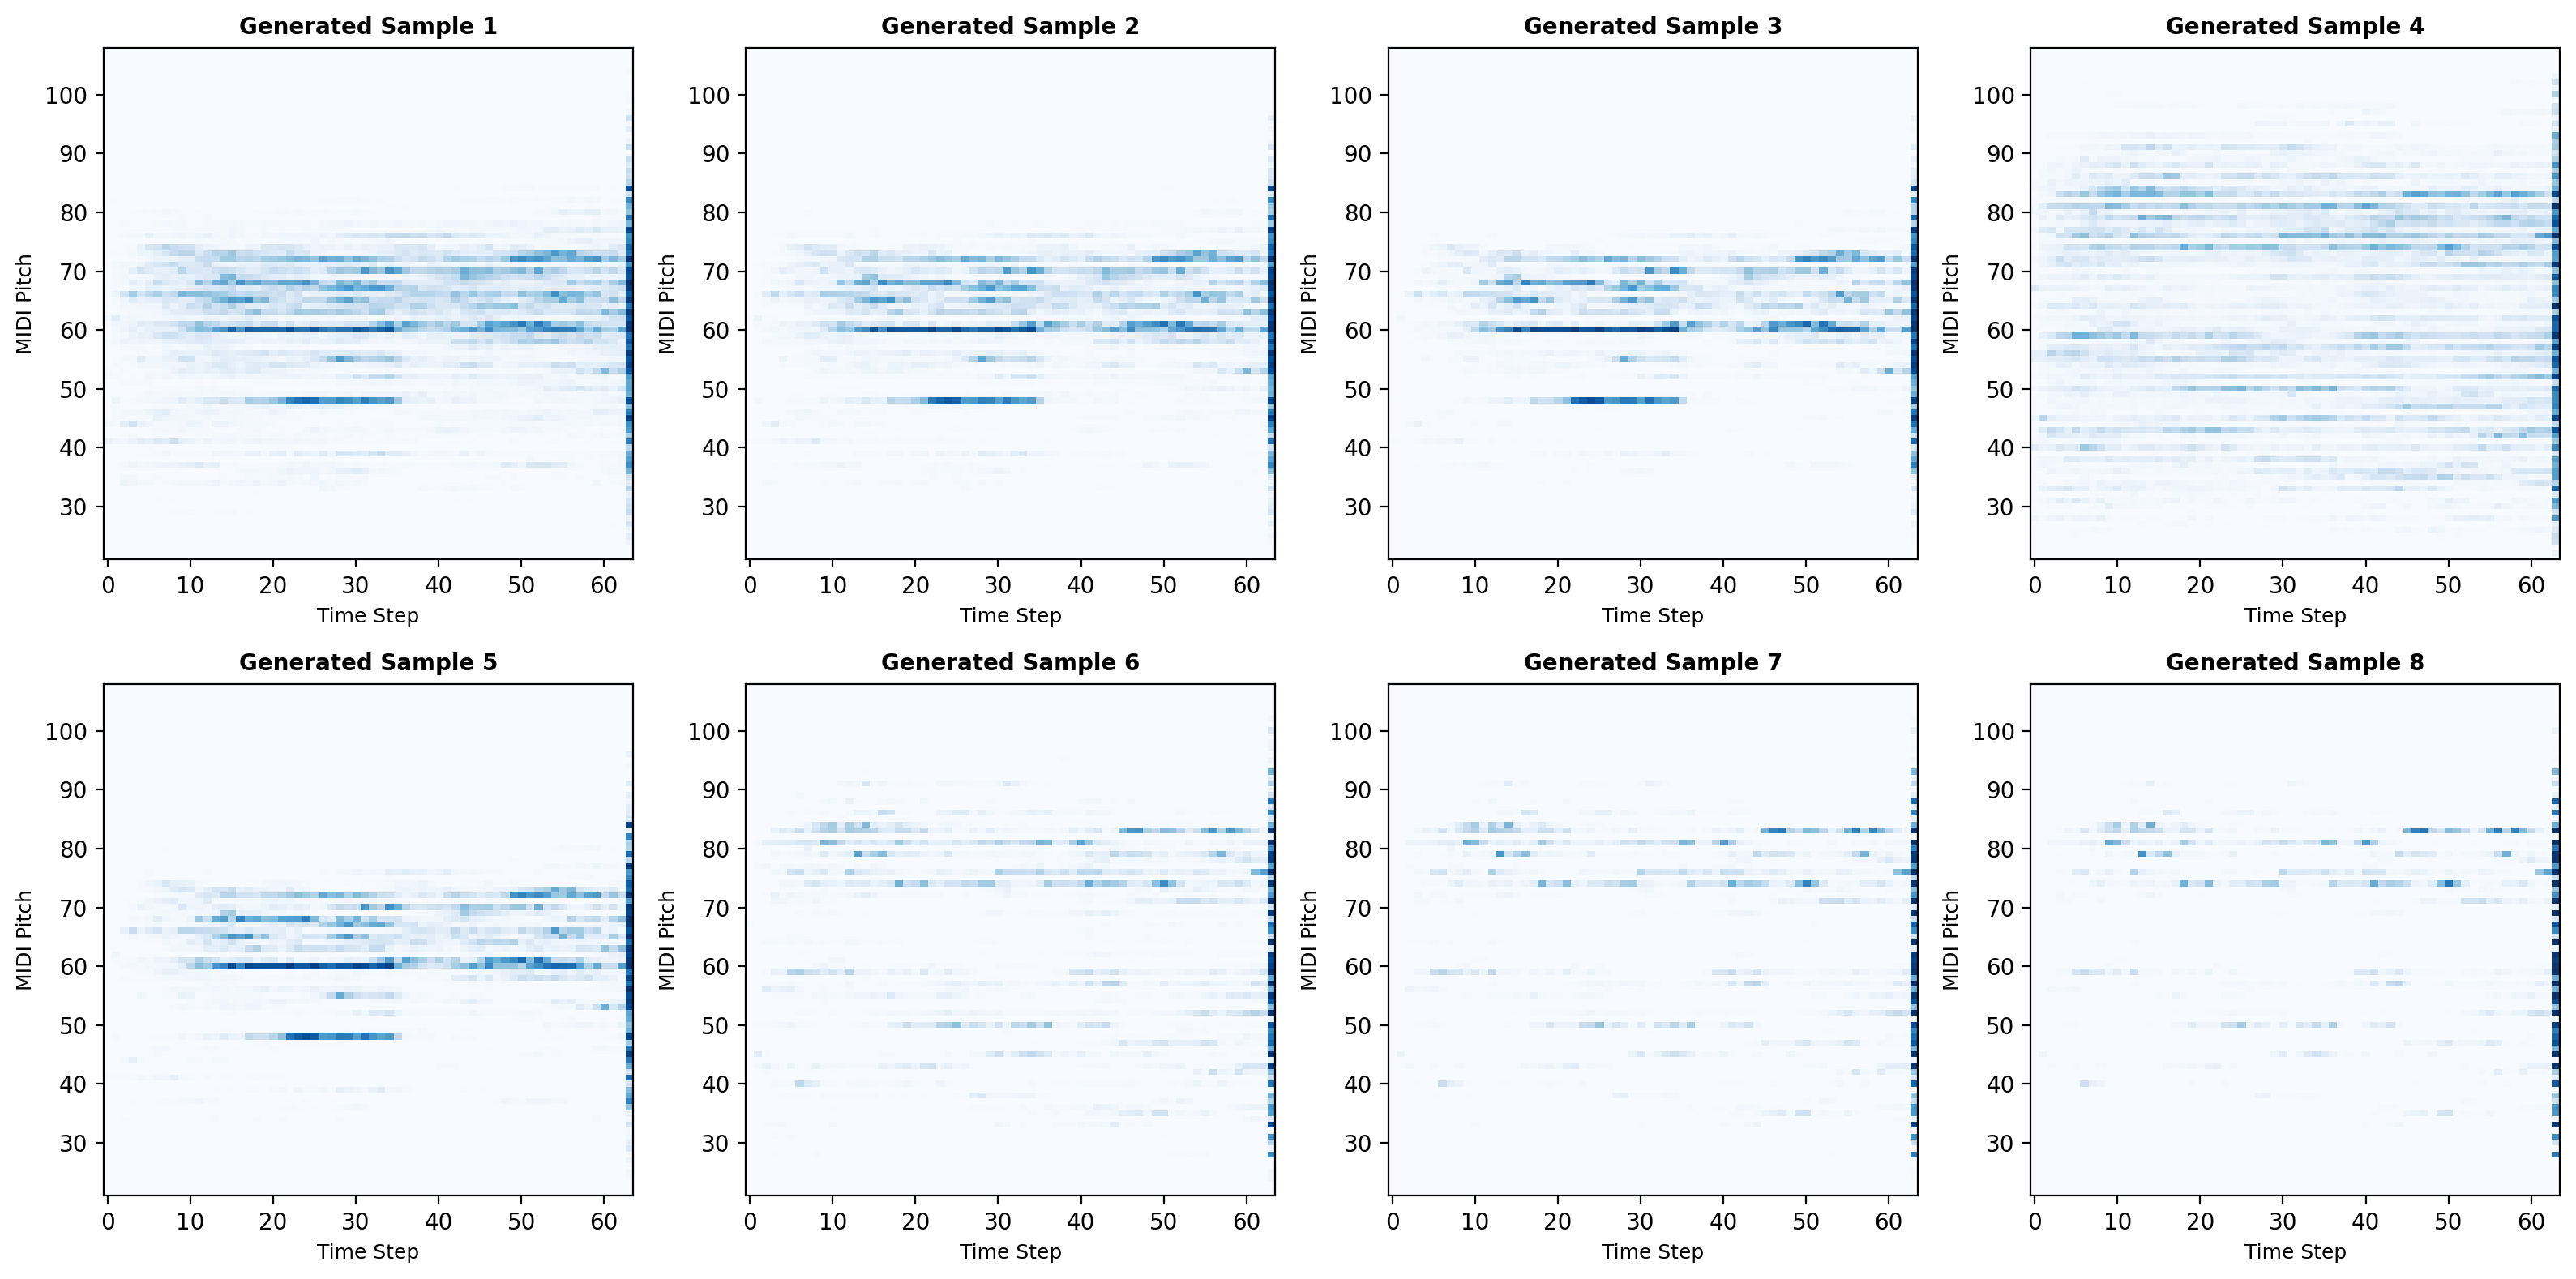

✓ Saved visualization to generated_music/generated_samples_visualization.png

CONVERTING TO MIDI FILES


Converting to MIDI: 100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


✓ Saved 8 MIDI files to generated_music/

GENERATED MUSIC SAMPLES

You can download and listen to these MIDI files:
  1. generated_music/sample_1.mid
  2. generated_music/sample_2.mid
  3. generated_music/sample_3.mid
  4. generated_music/sample_4.mid
  5. generated_music/sample_5.mid
  6. generated_music/sample_6.mid
  7. generated_music/sample_7.mid
  8. generated_music/sample_8.mid

GENERATION STATISTICS

Notes per sample:
  Mean: 181.4
  Min: 84
  Max: 301

Pitch ranges:
  Sample 1: MIDI 36-84 (span: 48 semitones)
  Sample 2: MIDI 36-84 (span: 48 semitones)
  Sample 3: MIDI 36-84 (span: 48 semitones)
  Sample 4: MIDI 28-100 (span: 72 semitones)
  Sample 5: MIDI 36-84 (span: 48 semitones)
  Sample 6: MIDI 28-93 (span: 65 semitones)
  Sample 7: MIDI 28-93 (span: 65 semitones)
  Sample 8: MIDI 28-93 (span: 65 semitones)

COMPARISON WITH TRAINING DATA

Training data:
  Mean notes: 363.0
  Std notes: 123.8

Generated data:
  Mean notes: 181.4
  Std notes: 74.8

GENERATING WITH DIFFEREN

In [ ]:
# Step 5: Generate Music with GAN + VAE
# Run this after Step 4

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pretty_midi
from IPython.display import Audio, display
import os

# Install fluidsynth for MIDI to audio conversion
print("Installing audio conversion dependencies...")
!apt-get install -y fluidsynth > /dev/null 2>&1
!pip install -q midi2audio

print("=" * 60)
print("STEP 5: GENERATING MUSIC WITH GAN + VAE")
print("=" * 60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

# Define model architectures (same as before)
class MusicVAE(nn.Module):
    def __init__(self, input_dim=64*128, hidden_dim=1024, latent_dim=512):
        super(MusicVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def decode(self, z):
        x = self.decoder(z)
        return x.view(-1, 64, 128)

class Generator(nn.Module):
    def __init__(self, noise_dim=128, latent_dim=512, hidden_dim=512):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, noise):
        return self.model(noise)

# Load models
print("\nLoading trained models...")

vae = MusicVAE().to(device)
vae.load_state_dict(torch.load('vae_model.pth', map_location=device))
vae.eval()
print("✓ VAE loaded")

generator = Generator().to(device)
generator.load_state_dict(torch.load('generator.pth', map_location=device))
generator.eval()
print("✓ Generator loaded")

# Load latent normalization stats
latent_stats = torch.load('latent_stats.pth', map_location=device)
latent_mean = latent_stats['mean'].to(device)
latent_std = latent_stats['std'].to(device)
print("✓ Latent normalization stats loaded")

# Generation function
def generate_music(num_samples=1, temperature=1.0):
    """
    Generate music samples

    Args:
        num_samples: Number of samples to generate
        temperature: Sampling temperature (higher = more random)

    Returns:
        piano_rolls: Generated piano rolls (num_samples, 64, 128)
    """
    with torch.no_grad():
        # Generate noise
        noise = torch.randn(num_samples, 128).to(device) * temperature

        # Generator: Noise -> Normalized Latent
        latent_normalized = generator(noise)

        # Denormalize latent vectors
        latent = latent_normalized * latent_std + latent_mean

        # VAE Decoder: Latent -> Piano Roll
        piano_rolls = vae.decode(latent)

        return piano_rolls.cpu().numpy()

# Piano roll to MIDI conversion
def piano_roll_to_midi(piano_roll, filename='generated_music.mid', threshold=0.5, tempo=120):
    """
    Convert piano roll to MIDI file

    Args:
        piano_roll: (64, 128) numpy array
        filename: Output filename
        threshold: Note activation threshold
        tempo: BPM
    """
    # Create PrettyMIDI object
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    # Time step in seconds (16th notes at given tempo)
    time_step = 60.0 / tempo / 4  # Quarter note / 4 = 16th note

    # Binarize piano roll
    piano_roll_binary = (piano_roll > threshold).astype(int)

    # Track active notes
    active_notes = {}  # pitch -> start_time

    for time_idx in range(piano_roll_binary.shape[0]):
        for pitch in range(piano_roll_binary.shape[1]):
            is_active = piano_roll_binary[time_idx, pitch]

            if is_active and pitch not in active_notes:
                # Note starts
                active_notes[pitch] = time_idx * time_step
            elif not is_active and pitch in active_notes:
                # Note ends
                start_time = active_notes[pitch]
                end_time = time_idx * time_step

                # Create note
                note = pretty_midi.Note(
                    velocity=80,
                    pitch=pitch,
                    start=start_time,
                    end=end_time
                )
                piano.notes.append(note)
                del active_notes[pitch]

    # Close any remaining notes
    final_time = piano_roll_binary.shape[0] * time_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(
            velocity=80,
            pitch=pitch,
            start=start_time,
            end=final_time
        )
        piano.notes.append(note)

    # Add instrument to MIDI
    midi.instruments.append(piano)

    # Save
    midi.write(filename)
    return midi

# Generate samples
print("\n" + "=" * 60)
print("GENERATING MUSIC SAMPLES")
print("=" * 60)

NUM_SAMPLES = 8
TEMPERATURE = 1.0

print(f"\nGenerating {NUM_SAMPLES} samples with temperature={TEMPERATURE}...")
generated_piano_rolls = generate_music(NUM_SAMPLES, temperature=TEMPERATURE)
print(f"✓ Generated {len(generated_piano_rolls)} piano rolls")

# Create output directory
os.makedirs('generated_music', exist_ok=True)

# Visualize generated samples
print("\n" + "=" * 60)
print("VISUALIZING GENERATED SAMPLES")
print("=" * 60)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(NUM_SAMPLES):
    ax = axes[i]
    ax.imshow(generated_piano_rolls[i].T, aspect='auto', cmap='Blues', origin='lower')
    ax.set_xlabel('Time Step', fontsize=9)
    ax.set_ylabel('MIDI Pitch', fontsize=9)
    ax.set_title(f'Generated Sample {i+1}', fontsize=10, fontweight='bold')
    ax.set_ylim([21, 108])  # Piano range

plt.tight_layout()
plt.savefig('generated_music/generated_samples_visualization.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved visualization to generated_music/generated_samples_visualization.png")

# Convert to MIDI and save
print("\n" + "=" * 60)
print("CONVERTING TO MIDI FILES")
print("=" * 60)

midi_files = []
for i in tqdm(range(NUM_SAMPLES), desc="Converting to MIDI"):
    filename = f'generated_music/sample_{i+1}.mid'

    # Try different thresholds to find best one
    threshold = 0.3  # Lower threshold to capture more notes

    midi = piano_roll_to_midi(
        generated_piano_rolls[i],
        filename=filename,
        threshold=threshold,
        tempo=120
    )
    midi_files.append(filename)

print(f"\n✓ Saved {len(midi_files)} MIDI files to generated_music/")

# Display audio players for generated music
print("\n" + "=" * 60)
print("GENERATED MUSIC SAMPLES")
print("=" * 60)

print("\nYou can download and listen to these MIDI files:")
for i, filename in enumerate(midi_files):
    print(f"  {i+1}. {filename}")

# Statistics about generated music
print("\n" + "=" * 60)
print("GENERATION STATISTICS")
print("=" * 60)

note_counts = []
pitch_ranges = []

for i, piano_roll in enumerate(generated_piano_rolls):
    # Count notes
    num_notes = (piano_roll > 0.3).sum()
    note_counts.append(num_notes)

    # Pitch range
    active_pitches = np.where((piano_roll > 0.3).any(axis=0))[0]
    if len(active_pitches) > 0:
        pitch_range = (active_pitches.min(), active_pitches.max())
        pitch_ranges.append(pitch_range)
    else:
        pitch_ranges.append((0, 0))

print(f"\nNotes per sample:")
print(f"  Mean: {np.mean(note_counts):.1f}")
print(f"  Min: {np.min(note_counts):.0f}")
print(f"  Max: {np.max(note_counts):.0f}")

print(f"\nPitch ranges:")
for i, (low, high) in enumerate(pitch_ranges):
    if low > 0:
        print(f"  Sample {i+1}: MIDI {low}-{high} (span: {high-low} semitones)")
    else:
        print(f"  Sample {i+1}: No notes detected")

# Compare with training data
print("\n" + "=" * 60)
print("COMPARISON WITH TRAINING DATA")
print("=" * 60)

train_piano_rolls = np.load('piano_rolls.npy')
train_note_counts = (train_piano_rolls > 0).sum(axis=(1, 2))

print(f"\nTraining data:")
print(f"  Mean notes: {train_note_counts.mean():.1f}")
print(f"  Std notes: {train_note_counts.std():.1f}")

print(f"\nGenerated data:")
print(f"  Mean notes: {np.mean(note_counts):.1f}")
print(f"  Std notes: {np.std(note_counts):.1f}")

# Generate additional samples with different temperatures
print("\n" + "=" * 60)
print("GENERATING WITH DIFFERENT TEMPERATURES")
print("=" * 60)

temperatures = [0.5, 1.0, 1.5]
print(f"\nTesting temperatures: {temperatures}")

for temp in temperatures:
    print(f"\nTemperature {temp}:")
    samples = generate_music(2, temperature=temp)

    for i, sample in enumerate(samples):
        filename = f'generated_music/temp_{temp}_sample_{i+1}.mid'
        piano_roll_to_midi(sample, filename=filename, threshold=0.3, tempo=120)
        print(f"  ✓ Saved {filename}")

print("\n" + "=" * 60)
print(" STEP 5 COMPLETE - MUSIC GENERATED!")
print("=" * 60)

print("\n" + "=" * 60)

print("=" * 60)

print("\nSummary:")
print("   Trained VAE on 1,071 piano tracks")
print("   Trained GAN to generate latent vectors")
print(f"   Generated {NUM_SAMPLES} + {len(temperatures)*2} music samples")
print(f"   All files saved to generated_music/")

print("\nNext steps:")
print("  1. Listen to the generated MIDI files")
print("  2. Try different temperatures for variety")
print("  3. Adjust threshold in piano_roll_to_midi() for note density")
print("  4. Generate more samples!")

print("\nFiles created:")
print("  - generated_music/sample_1.mid to sample_8.mid")
print("  - generated_music/temp_*.mid (different temperatures)")
print("  - generated_music/generated_samples_visualization.png")

COMPREHENSIVE EVALUATION METRICS

Dataset sizes:
  Training samples: 1071
  Generated samples: 8

1. NOTE DENSITY ANALYSIS

Overall note density (% active):
  Training: 4.43%
  Generated: 6.01%
  Difference: 1.58%


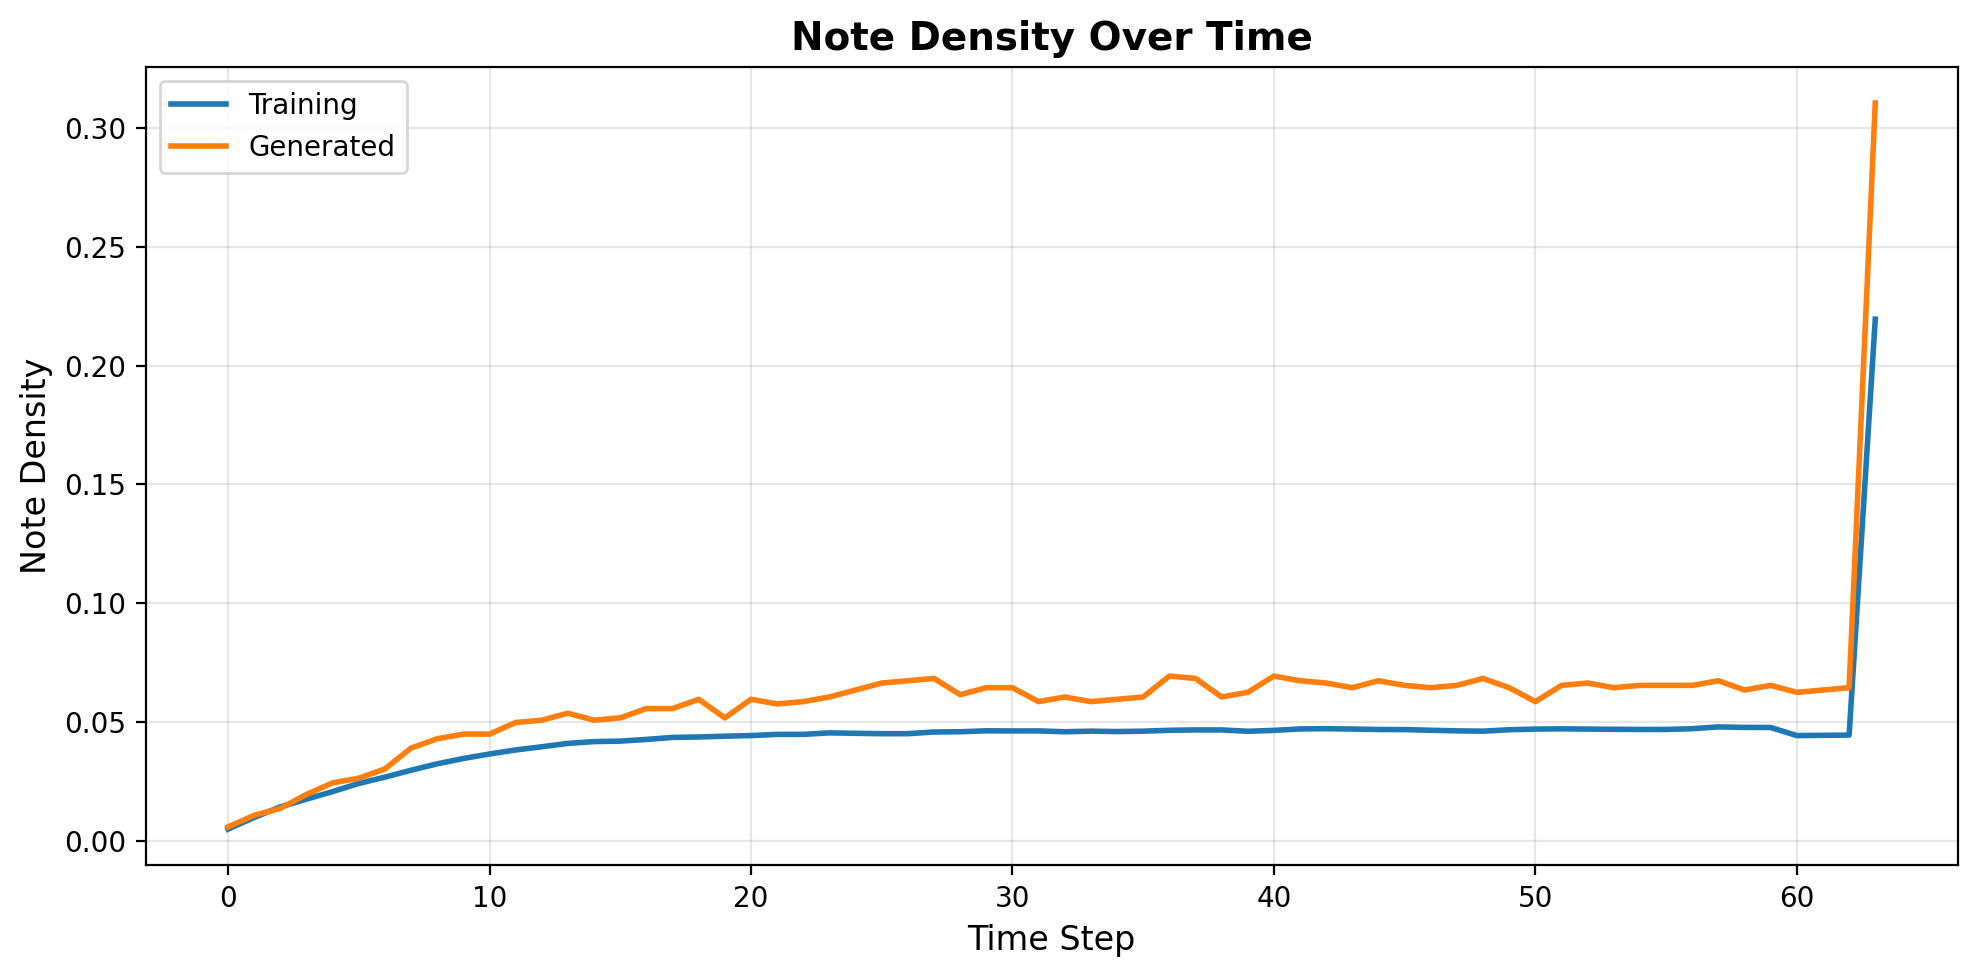


2. NOTES PER SAMPLE STATISTICS

Notes per sample:
  Training: 363.0 ± 123.8
  Generated: 492.1 ± 158.0
  Min/Max (train): 45 / 987
  Min/Max (gen): 269 / 850


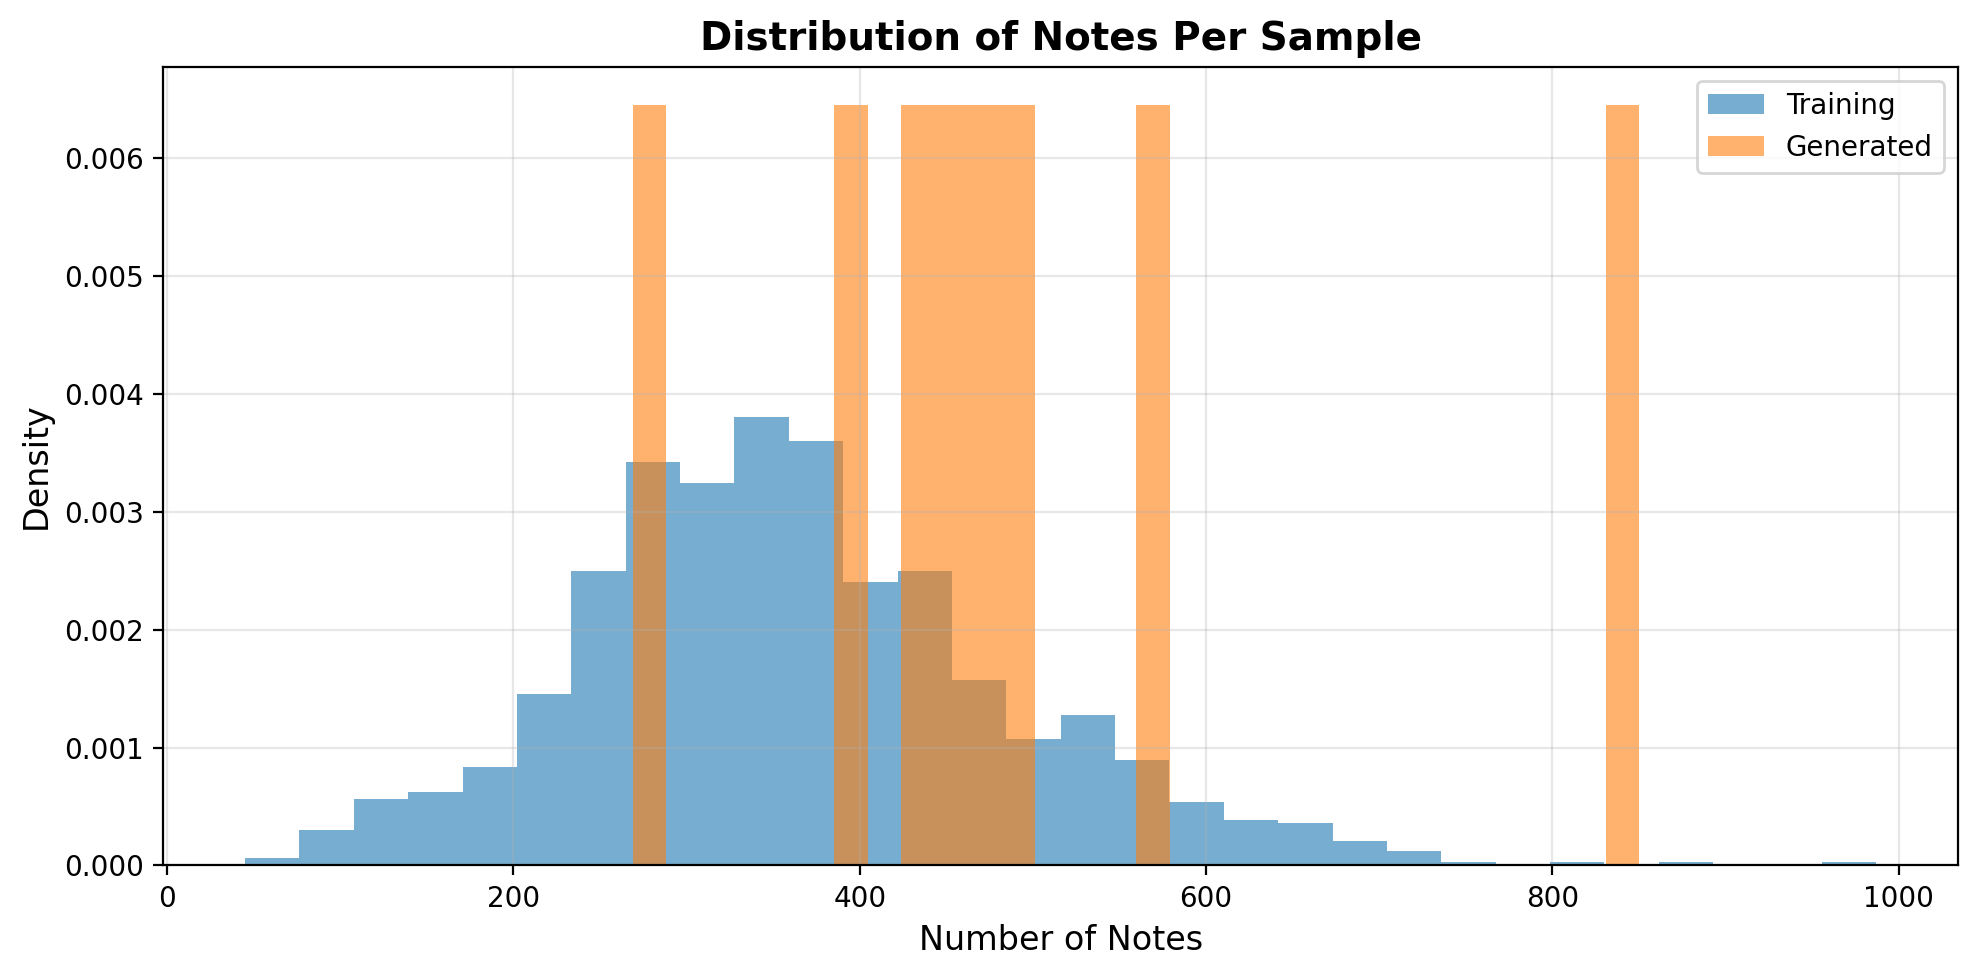


Wasserstein Distance: 129.42

3. PITCH RANGE ANALYSIS

Active pitches:
  Training: 84/128
  Generated: 65/128

Pitch range (MIDI):
  Training: 22 - 105 (span: 83)
  Generated: 24 - 90 (span: 66)


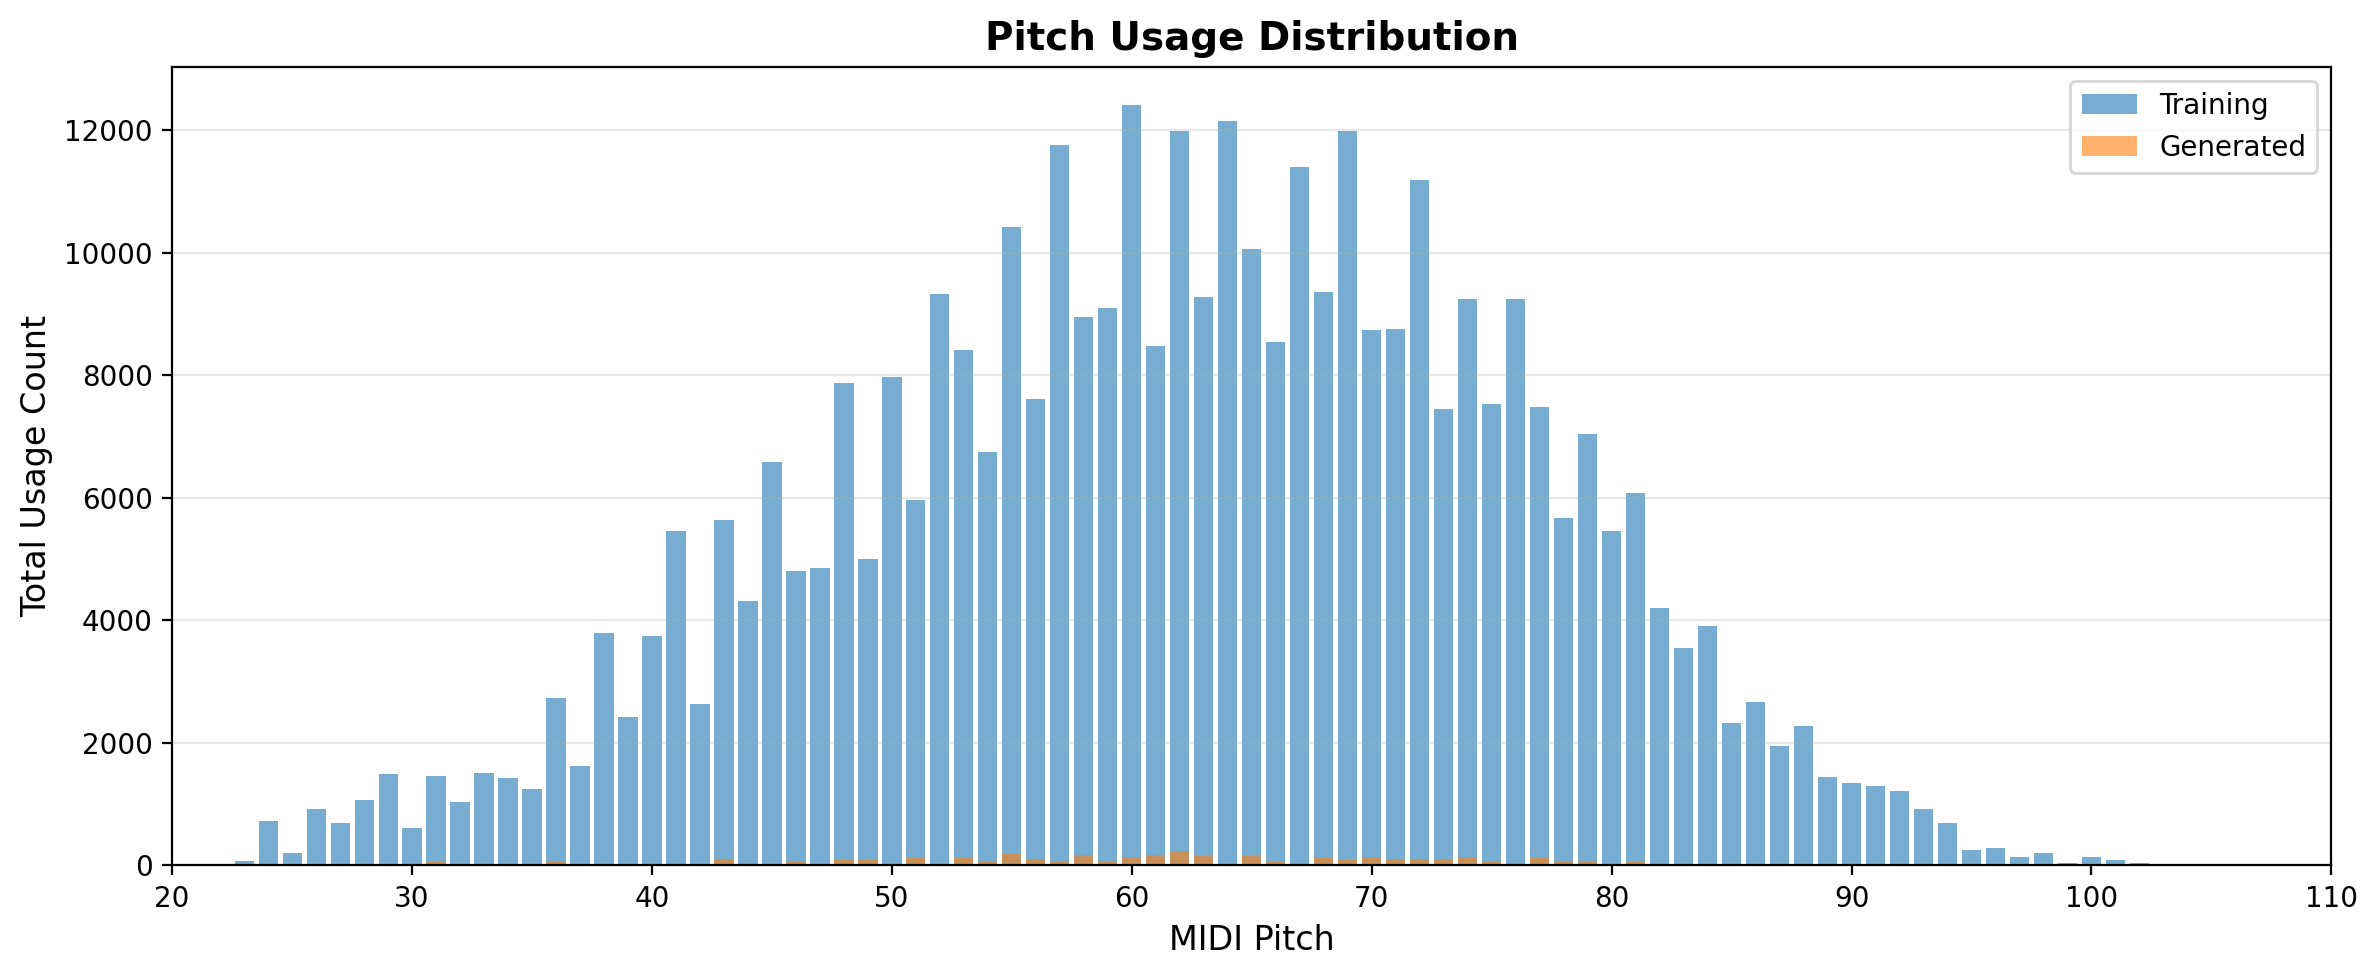


4. POLYPHONY ANALYSIS

Average polyphony (simultaneous notes):
  Training: 5.67
  Generated: 7.69


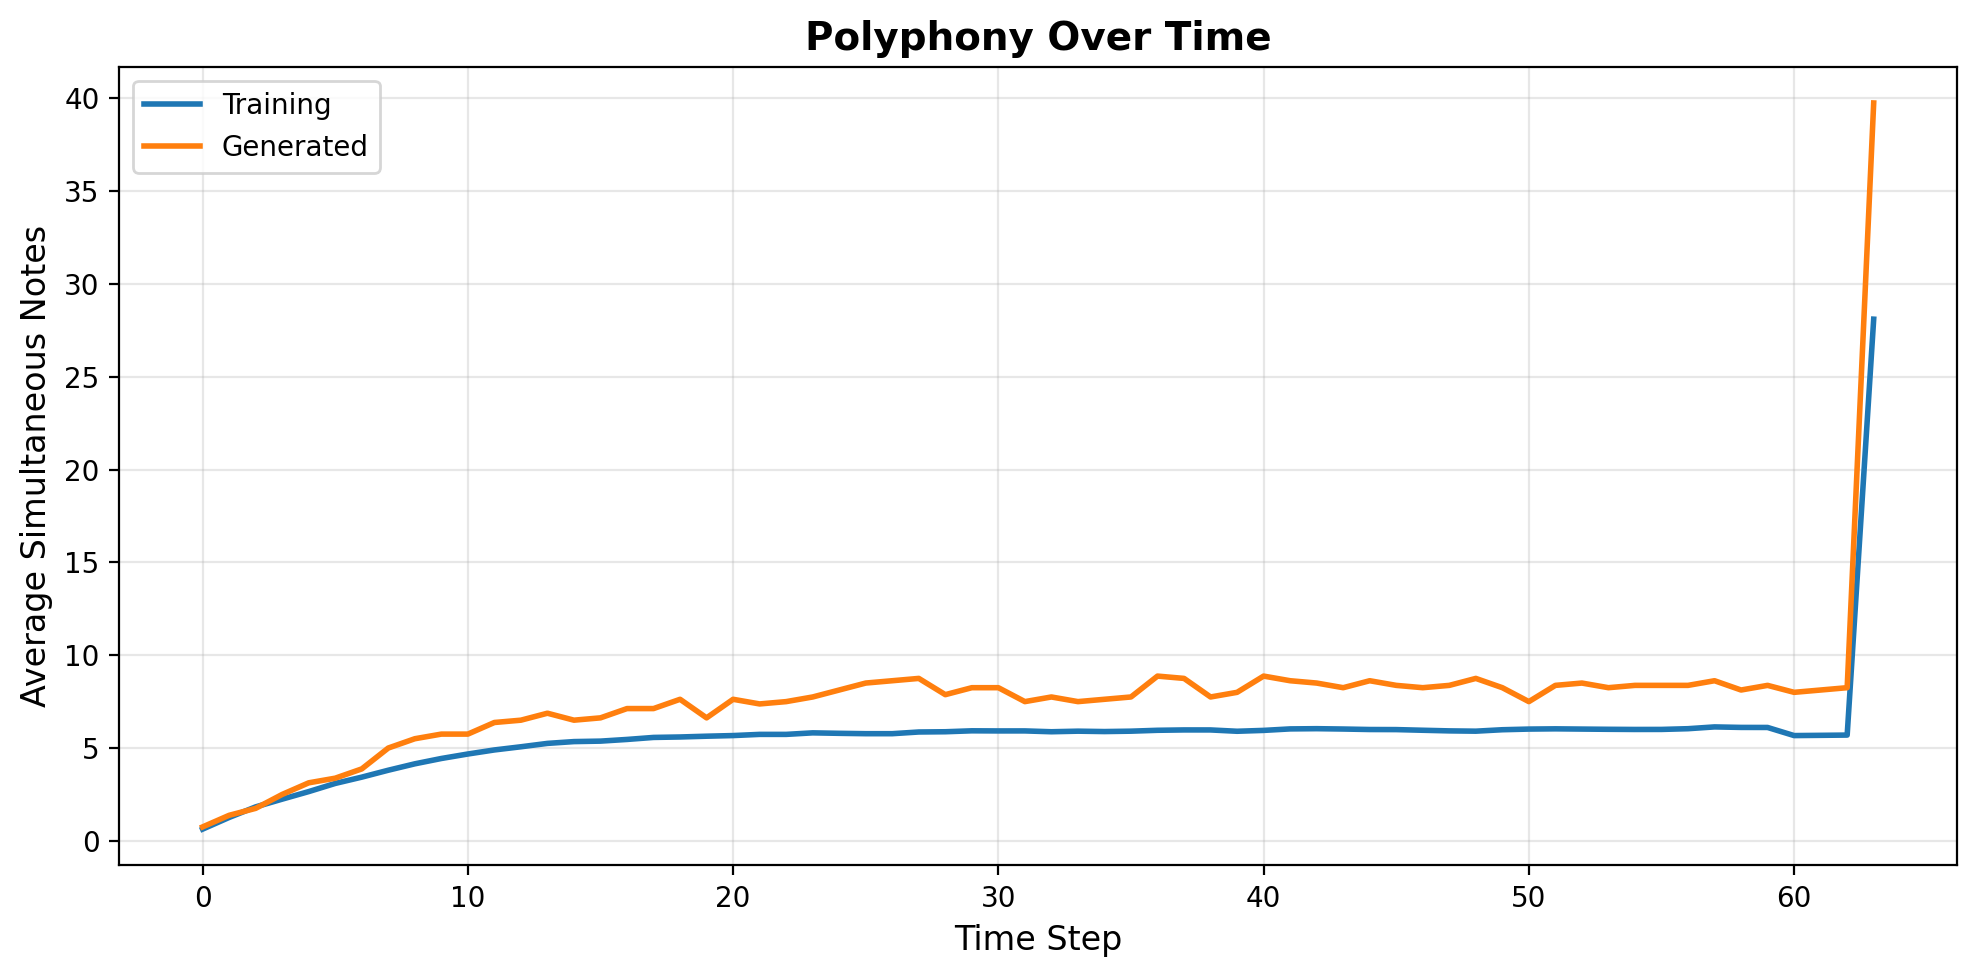


5. EMPTY SAMPLES DETECTION

Empty samples (no notes):
  Training: 0/1071 (0.0%)
  Generated: 0/8 (0.0%)

6. PITCH CLASS DISTRIBUTION SIMILARITY

KL Divergence (pitch distributions): 0.5703
  (Lower is better; 0 = identical distributions)

7. TEMPORAL CONTINUITY ANALYSIS


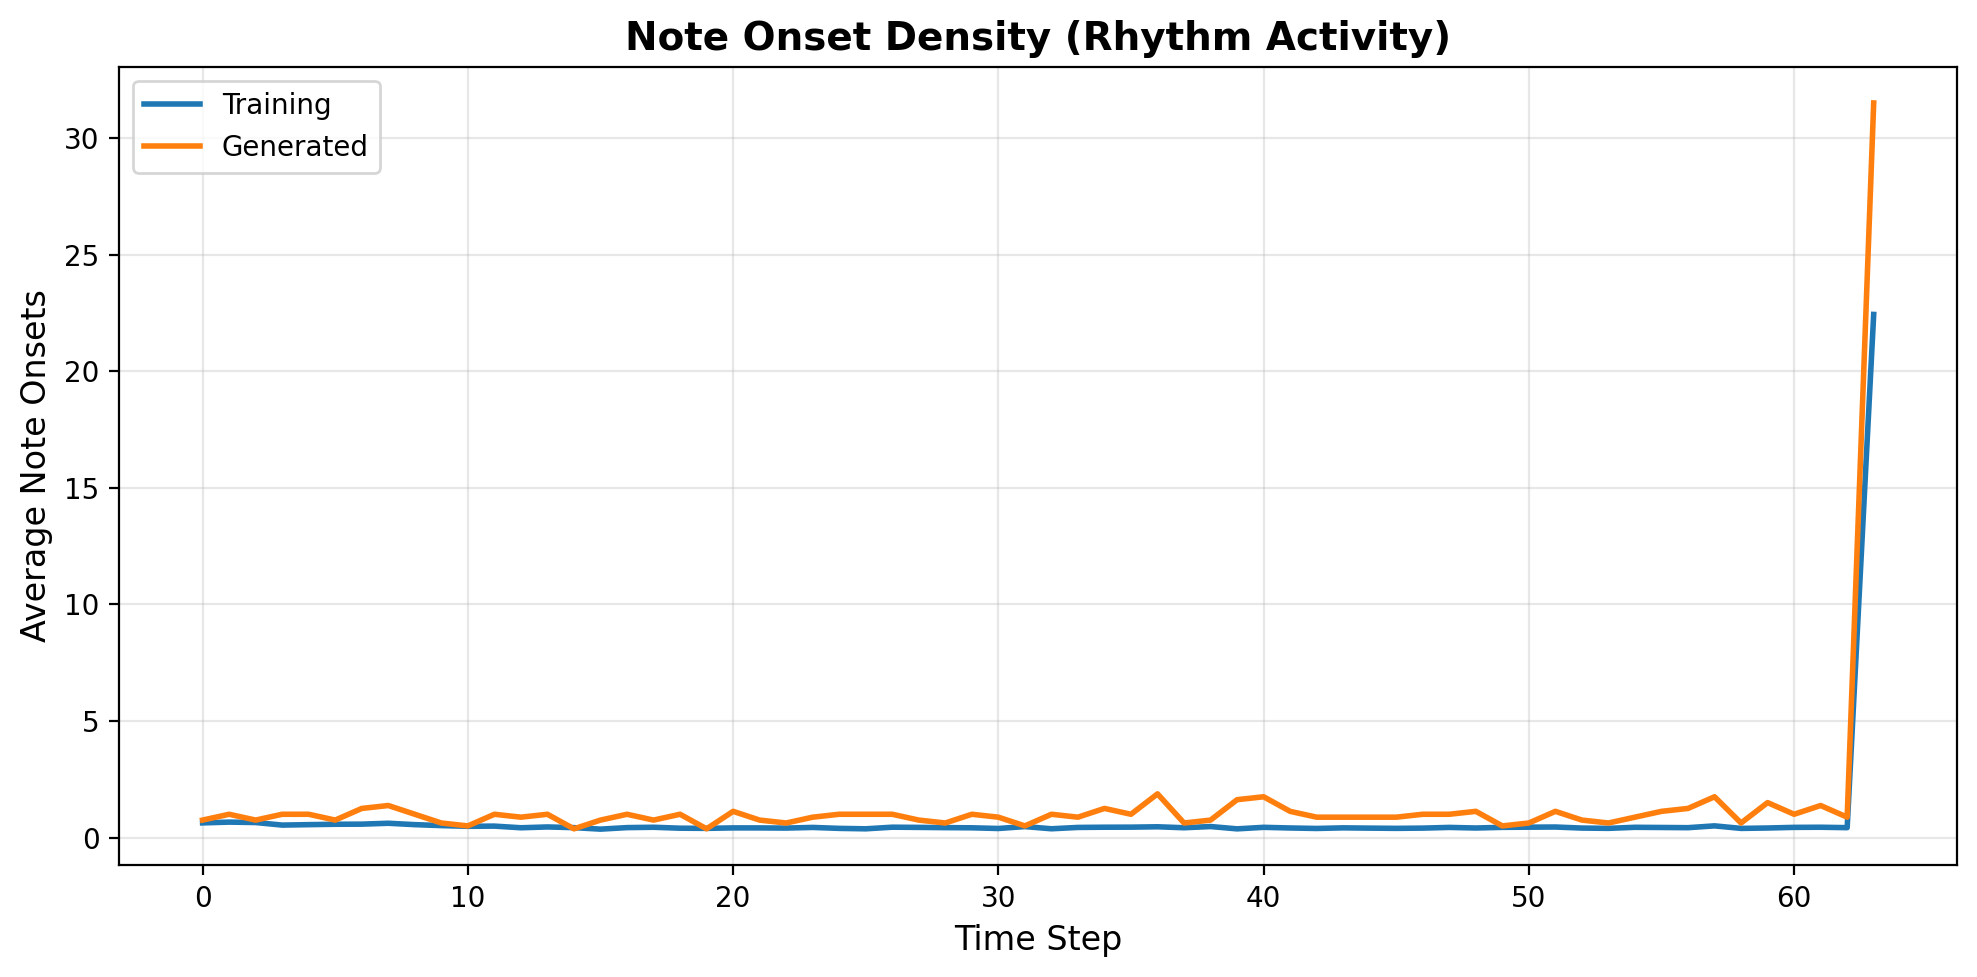


Average onsets per timestep:
  Training: 0.79
  Generated: 1.43

SUMMARY METRICS TABLE

╔═══════════════════════════════════════╦═══════════╦═══════════╗
║ Metric                                ║ Training  ║ Generated ║
╠═══════════════════════════════════════╬═══════════╬═══════════╣
║ Note Density (%)                      ║     4.43% ║     6.01% ║
║ Avg Notes per Sample                  ║     363.0 ║     492.1 ║
║ Avg Polyphony (simultaneous notes)    ║      5.67 ║      7.69 ║
║ Active Pitches                        ║        84/128 ║        65/128 ║
║ Empty Samples                         ║         0 ║         0 ║
║ Avg Onsets per Timestep               ║      0.79 ║      1.43 ║
╚═══════════════════════════════════════╩═══════════╩═══════════╝

Additional Metrics:
  • Wasserstein Distance (notes): 129.42
  • KL Divergence (pitch dist): 0.5703


✓ All metrics calculated and saved!
✓ Visualizations saved to metric_*.png files
✓ Summary saved to evaluation_metrics.txt


In [ ]:
# Evaluation Metrics for Generated Music
# Add this after Step 5 generation

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from scipy.special import kl_div

print("=" * 60)
print("COMPREHENSIVE EVALUATION METRICS")
print("=" * 60)

# Load data
train_piano_rolls = np.load('piano_rolls.npy')
generated_piano_rolls = generated_piano_rolls  # From Step 5

THRESHOLD = 0.3  # Note activation threshold

print(f"\nDataset sizes:")
print(f"  Training samples: {len(train_piano_rolls)}")
print(f"  Generated samples: {len(generated_piano_rolls)}")

# ============================================
# 1. NOTE DENSITY METRICS
# ============================================
print("\n" + "=" * 60)
print("1. NOTE DENSITY ANALYSIS")
print("=" * 60)

train_binary = (train_piano_rolls > 0).astype(float)
gen_binary = (generated_piano_rolls > THRESHOLD).astype(float)

train_density = train_binary.mean()
gen_density = gen_binary.mean()

print(f"\nOverall note density (% active):")
print(f"  Training: {train_density*100:.2f}%")
print(f"  Generated: {gen_density*100:.2f}%")
print(f"  Difference: {abs(train_density - gen_density)*100:.2f}%")

# Density over time
train_density_per_step = train_binary.mean(axis=(0, 2))
gen_density_per_step = gen_binary.mean(axis=(0, 2))

plt.figure(figsize=(10, 5))
plt.plot(train_density_per_step, label='Training', linewidth=2)
plt.plot(gen_density_per_step, label='Generated', linewidth=2)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Note Density', fontsize=12)
plt.title('Note Density Over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('metric_density_over_time.png', dpi=100)
plt.show()

# ============================================
# 2. NOTES PER SAMPLE
# ============================================
print("\n" + "=" * 60)
print("2. NOTES PER SAMPLE STATISTICS")
print("=" * 60)

train_notes = train_binary.sum(axis=(1, 2))
gen_notes = gen_binary.sum(axis=(1, 2))

print(f"\nNotes per sample:")
print(f"  Training: {train_notes.mean():.1f} ± {train_notes.std():.1f}")
print(f"  Generated: {gen_notes.mean():.1f} ± {gen_notes.std():.1f}")
print(f"  Min/Max (train): {train_notes.min():.0f} / {train_notes.max():.0f}")
print(f"  Min/Max (gen): {gen_notes.min():.0f} / {gen_notes.max():.0f}")

# Histogram comparison
plt.figure(figsize=(10, 5))
plt.hist(train_notes, bins=30, alpha=0.6, label='Training', density=True)
plt.hist(gen_notes, bins=30, alpha=0.6, label='Generated', density=True)
plt.xlabel('Number of Notes', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Notes Per Sample', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('metric_notes_distribution.png', dpi=100)
plt.show()

# Wasserstein distance (Earth Mover's Distance)
wd = wasserstein_distance(train_notes, gen_notes)
print(f"\nWasserstein Distance: {wd:.2f}")

# ============================================
# 3. PITCH RANGE ANALYSIS
# ============================================
print("\n" + "=" * 60)
print("3. PITCH RANGE ANALYSIS")
print("=" * 60)

train_pitch_usage = train_binary.sum(axis=(0, 1))  # Sum over samples and time
gen_pitch_usage = gen_binary.sum(axis=(0, 1))

train_active_pitches = np.where(train_pitch_usage > 0)[0]
gen_active_pitches = np.where(gen_pitch_usage > 0)[0]

print(f"\nActive pitches:")
print(f"  Training: {len(train_active_pitches)}/128")
print(f"  Generated: {len(gen_active_pitches)}/128")

if len(train_active_pitches) > 0:
    print(f"\nPitch range (MIDI):")
    print(f"  Training: {train_active_pitches.min()} - {train_active_pitches.max()} (span: {train_active_pitches.max() - train_active_pitches.min()})")
if len(gen_active_pitches) > 0:
    print(f"  Generated: {gen_active_pitches.min()} - {gen_active_pitches.max()} (span: {gen_active_pitches.max() - gen_active_pitches.min()})")

# Pitch usage histogram
plt.figure(figsize=(12, 5))
plt.bar(range(128), train_pitch_usage, alpha=0.6, label='Training')
plt.bar(range(128), gen_pitch_usage, alpha=0.6, label='Generated')
plt.xlabel('MIDI Pitch', fontsize=12)
plt.ylabel('Total Usage Count', fontsize=12)
plt.title('Pitch Usage Distribution', fontsize=14, fontweight='bold')
plt.xlim([20, 110])  # Piano range
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('metric_pitch_distribution.png', dpi=100)
plt.show()

# ============================================
# 4. POLYPHONY (NOTES PER TIMESTEP)
# ============================================
print("\n" + "=" * 60)
print("4. POLYPHONY ANALYSIS")
print("=" * 60)

train_polyphony = train_binary.sum(axis=2)  # Notes per timestep
gen_polyphony = gen_binary.sum(axis=2)

train_poly_mean = train_polyphony.mean(axis=0)  # Average per timestep
gen_poly_mean = gen_polyphony.mean(axis=0)

print(f"\nAverage polyphony (simultaneous notes):")
print(f"  Training: {train_polyphony.mean():.2f}")
print(f"  Generated: {gen_polyphony.mean():.2f}")

plt.figure(figsize=(10, 5))
plt.plot(train_poly_mean, label='Training', linewidth=2)
plt.plot(gen_poly_mean, label='Generated', linewidth=2)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Simultaneous Notes', fontsize=12)
plt.title('Polyphony Over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('metric_polyphony.png', dpi=100)
plt.show()

# ============================================
# 5. EMPTY SAMPLES DETECTION
# ============================================
print("\n" + "=" * 60)
print("5. EMPTY SAMPLES DETECTION")
print("=" * 60)

train_empty = (train_notes == 0).sum()
gen_empty = (gen_notes == 0).sum()

print(f"\nEmpty samples (no notes):")
print(f"  Training: {train_empty}/{len(train_piano_rolls)} ({train_empty/len(train_piano_rolls)*100:.1f}%)")
print(f"  Generated: {gen_empty}/{len(generated_piano_rolls)} ({gen_empty/len(generated_piano_rolls)*100:.1f}%)")

# ============================================
# 6. PITCH CLASS DISTRIBUTION (KL DIVERGENCE)
# ============================================
print("\n" + "=" * 60)
print("6. PITCH CLASS DISTRIBUTION SIMILARITY")
print("=" * 60)

# Normalize to probability distributions
train_pitch_dist = train_pitch_usage / (train_pitch_usage.sum() + 1e-10)
gen_pitch_dist = gen_pitch_usage / (gen_pitch_usage.sum() + 1e-10)

# KL Divergence (lower is better)
kl_divergence = np.sum(kl_div(train_pitch_dist + 1e-10, gen_pitch_dist + 1e-10))
print(f"\nKL Divergence (pitch distributions): {kl_divergence:.4f}")
print("  (Lower is better; 0 = identical distributions)")

# ============================================
# 7. TEMPORAL CONTINUITY
# ============================================
print("\n" + "=" * 60)
print("7. TEMPORAL CONTINUITY ANALYSIS")
print("=" * 60)

# Measure note onset density (how many notes start at each timestep)
def calculate_onsets(piano_rolls_binary):
    """Calculate note onsets (transitions from 0 to 1)"""
    onsets = np.zeros_like(piano_rolls_binary)
    onsets[:, 0, :] = piano_rolls_binary[:, 0, :]  # First timestep
    onsets[:, 1:, :] = np.diff(piano_rolls_binary, axis=1) > 0
    return onsets

train_onsets = calculate_onsets(train_binary)
gen_onsets = calculate_onsets(gen_binary)

train_onset_density = train_onsets.sum(axis=(0, 2)) / len(train_piano_rolls)
gen_onset_density = gen_onsets.sum(axis=(0, 2)) / len(generated_piano_rolls)

plt.figure(figsize=(10, 5))
plt.plot(train_onset_density, label='Training', linewidth=2)
plt.plot(gen_onset_density, label='Generated', linewidth=2)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Note Onsets', fontsize=12)
plt.title('Note Onset Density (Rhythm Activity)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('metric_onset_density.png', dpi=100)
plt.show()

print(f"\nAverage onsets per timestep:")
print(f"  Training: {train_onsets.sum(axis=2).mean():.2f}")
print(f"  Generated: {gen_onsets.sum(axis=2).mean():.2f}")

# ============================================
# 8. SUMMARY METRICS TABLE
# ============================================
print("\n" + "=" * 60)
print("SUMMARY METRICS TABLE")
print("=" * 60)

summary = f"""
╔═══════════════════════════════════════╦═══════════╦═══════════╗
║ Metric                                ║ Training  ║ Generated ║
╠═══════════════════════════════════════╬═══════════╬═══════════╣
║ Note Density (%)                      ║ {train_density*100:>8.2f}% ║ {gen_density*100:>8.2f}% ║
║ Avg Notes per Sample                  ║ {train_notes.mean():>9.1f} ║ {gen_notes.mean():>9.1f} ║
║ Avg Polyphony (simultaneous notes)    ║ {train_polyphony.mean():>9.2f} ║ {gen_polyphony.mean():>9.2f} ║
║ Active Pitches                        ║ {len(train_active_pitches):>9}/128 ║ {len(gen_active_pitches):>9}/128 ║
║ Empty Samples                         ║ {train_empty:>9} ║ {gen_empty:>9} ║
║ Avg Onsets per Timestep               ║ {train_onsets.sum(axis=2).mean():>9.2f} ║ {gen_onsets.sum(axis=2).mean():>9.2f} ║
╚═══════════════════════════════════════╩═══════════╩═══════════╝

Additional Metrics:
  • Wasserstein Distance (notes): {wd:.2f}
  • KL Divergence (pitch dist): {kl_divergence:.4f}
"""

print(summary)

# Save metrics to file
with open('evaluation_metrics.txt', 'w') as f:
    f.write(summary)

print("\n✓ All metrics calculated and saved!")
print("✓ Visualizations saved to metric_*.png files")
print("✓ Summary saved to evaluation_metrics.txt")